In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns 
import time
import shap
import wordcloud

C:\Users\R_A\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from IPython.display import IFrame

In [3]:
df = pd.read_csv("Obfuscated-MalMem2022.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True) # shuffle the data(For Random Forest)
df.head()
df['Class'].value_counts()

Class
Malware    29298
Benign     29298
Name: count, dtype: int64

In [4]:
df['Class']=df.Class.map({'Malware':1,'Benign':0})

In [5]:
# Creating a column based on Malware type
#0-Benign
#1-TrojanHorse
#2-spyware
#3-Ransomware

df['Malware_type'] = ''

for i, Category in enumerate(df['Category']):
    if Category.startswith('B'):
        df.loc[i, 'Malware_type'] = 0
    elif Category.startswith('T'):
        df.loc[i, 'Malware_type'] = 1
    elif Category.startswith('S'):
        df.loc[i, 'Malware_type'] = 2
    elif Category.startswith('R'):
        df.loc[i, 'Malware_type'] = 3
    else:
        df.loc[i, 'Malware_type'] = 'unknown'

df['Malware_type'] = df['Malware_type'].astype('int64')


df[["Category", "Malware_type"]]


Category  Malware_type
0      Ransomware-Conti-0acab6c956e35f8d4b37df3e2c381...             3
1                                                 Benign             0
2      Spyware-CWS-0b5f27693d84662626b7367a01c8bc32c8...             2
3                                                 Benign             0
4      Ransomware-Shade-3e30ddddc154e46d42c833c052be0...             3
...                                                  ...           ...
58591  Trojan-Zeus-2f0eaed78213566b74034c4090df3a6fd9...             1
58592  Spyware-CWS-0b74ad6861c4e82cb8295eb3c6bdb2e7e7...             2
58593                                             Benign             0
58594                                             Benign             0
58595  Ransomware-Ako-0bf17586b1d3a67d5b6eb4a1e53e9bd...             3

[58596 rows x 2 columns]

In [6]:
#Display the malware type with respective to the index
df['Malware_type'].value_counts().sort_index()

Malware_type
0    29298
1     9487
2    10020
3     9791
Name: count, dtype: int64

In [7]:
# Creating a column based on Malware Subtypes
#Benign-0
#zeus-1.1
#Emotet-1.2
#Refroso-1.3
#Scar-1.4
#Reconyc-1.5
#180solution-2.1
#CWS-2.2
#Gator-2.3
#Transponder-2.4
#TIBS-2.5
#Conti-3.1
#Maze-3.2
#Pysa-3.3
#Ako-3.4
#Shade-3.5

df['Malware_subtype'] = ''

df.loc[df['Category'].str.contains('Benign'), 'Malware_subtype'] = 0
df.loc[df['Category'].str.contains('Zeus'), 'Malware_subtype'] = 1.1
df.loc[df['Category'].str.contains('Emotet'), 'Malware_subtype'] = 1.2
df.loc[df['Category'].str.contains('Refroso'), 'Malware_subtype'] = 1.3
df.loc[df['Category'].str.contains('Scar'), 'Malware_subtype'] = 1.4
df.loc[df['Category'].str.contains('Reconyc'), 'Malware_subtype'] = 1.5
df.loc[df['Category'].str.contains('180solutions'), 'Malware_subtype'] = 2.1
df.loc[df['Category'].str.contains('CWS'), 'Malware_subtype'] = 2.2
df.loc[df['Category'].str.contains('Gator'), 'Malware_subtype'] = 2.3
df.loc[df['Category'].str.contains('Transponder'), 'Malware_subtype'] = 2.4
df.loc[df['Category'].str.contains('TIBS'), 'Malware_subtype'] = 2.5
df.loc[df['Category'].str.contains('Conti'), 'Malware_subtype'] = 3.1
df.loc[df['Category'].str.contains('Maze'), 'Malware_subtype'] = 3.2
df.loc[df['Category'].str.contains('Pysa'), 'Malware_subtype'] = 3.3
df.loc[df['Category'].str.contains('Ako'), 'Malware_subtype'] = 3.4
df.loc[df['Category'].str.contains('Shade'), 'Malware_subtype'] = 3.5

# Displaying the final dataframe
df[["Category", "Malware_subtype"]]

Category Malware_subtype
0      Ransomware-Conti-0acab6c956e35f8d4b37df3e2c381...             3.1
1                                                 Benign               0
2      Spyware-CWS-0b5f27693d84662626b7367a01c8bc32c8...             2.2
3                                                 Benign               0
4      Ransomware-Shade-3e30ddddc154e46d42c833c052be0...             3.5
...                                                  ...             ...
58591  Trojan-Zeus-2f0eaed78213566b74034c4090df3a6fd9...             1.1
58592  Spyware-CWS-0b74ad6861c4e82cb8295eb3c6bdb2e7e7...             2.2
58593                                             Benign               0
58594                                             Benign               0
58595  Ransomware-Ako-0bf17586b1d3a67d5b6eb4a1e53e9bd...             3.4

[58596 rows x 2 columns]

In [8]:
#Display the malware Subtype with respective to the index
#value_counts() used for Counts unique values in a column
df['Malware_subtype'].value_counts().sort_index()

Malware_subtype
0      29298
1.1     1950
1.2     1967
1.3     2000
1.4     2000
1.5     1570
2.1     2000
2.2     2000
2.3     2200
2.4     2410
2.5     1410
3.1     1988
3.2     1958
3.3     1717
3.4     2000
3.5     2128
Name: count, dtype: int64

In [9]:
#Removing Invariants(By finding the column have a fixed values)
fixed_columns = [col for col in df.columns if df[col].nunique() == 1]
fixed_columns

['pslist.nprocs64bit', 'handles.nport', 'svcscan.interactive_process_services']

In [10]:
#Feature Selection(Dropping specified column)
X = df.drop(['Category','pslist.nprocs64bit', 'handles.nport',
       'svcscan.interactive_process_services','Class','Malware_type','Malware_subtype'],axis=1)
Y = df["Class"]

In [11]:
#Methodology

In [12]:
#Binary classsification for Baseline malware detection

def evaluate_classifier_with_metrics(X,Y,model,model_name,cv_folds=10):
    
    # Initialise a cross-validation splitter(Creation of Fold)
    stratified_kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    acc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_index, test_index in stratified_kfold.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        # Scaling(MinMax_Normalization)
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train the model on the training set
        model.fit(X_train_scaled, y_train)

        # Make predictions on the test set
        predicted = model.predict(X_test_scaled)

        # Calculate evaluation metrics for the current fold
        acc = accuracy_score(y_test, predicted)
        precision = precision_score(y_test, predicted, average='weighted')
        recall = recall_score(y_test, predicted, average='weighted')
        f1 = f1_score(y_test, predicted, average='weighted')

        # Append metrics to the created lists
        acc_scores.append(acc)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    # Calculate average metrics across various folds
    avg_acc_score = np.mean(acc_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_f1 = np.mean(f1_scores)
    
    print('Cross-Validation Report')

    # Print the results for K-Fold Cross-Validation
    print('Result For each fold:')
    print('Accuracy  - {}'.format(acc_scores))
    print('Precision - {}'.format(precision_scores))
    print('Recall  - {}'.format(recall_scores))
    print('F1-Score - {}'.format(f1_scores))
    print('Average Scores:')
    print(' Accuracy : {}'.format(avg_acc_score))
    print(' Precision : {}'.format(avg_precision))
    print(' Recall : {}'.format(avg_recall))
    print(' F1-Score : {}'.format(avg_f1))
    
    stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        # Split the data into training and testing DataFrames using stratified split
    for train_index, test_index in stratified_splitter.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]  
        scaler = MinMaxScaler()
        # Fit the features X_train to the [0, 1] range
        X_train = scaler.fit_transform(X_train)
        # Transform the X_test features to the [0, 1] range 
        X_test = scaler.transform(X_test)
   
    # Train the model on the entire training dataset
    start_time_test_train = time.time()
    model.fit(X_train, y_train)
    end_time_test_train = time.time()
    test_train_time = (end_time_test_train - start_time_test_train)/len(y_train)

    # Measure the prediction time for test data
    start_time_test = time.time()
    test_predicted = model.predict(X_test)
    end_time_test = time.time()
    test_prediction_time = (end_time_test - start_time_test)/len(y_test)

    # Calculate evaluation metrics for the test data
    test_accuracy = accuracy_score(y_test, test_predicted)
    test_precision = precision_score(y_test, test_predicted, average='weighted')
    test_recall = recall_score(y_test, test_predicted, average='weighted')
    test_f1 = f1_score(y_test, test_predicted, average='weighted')

    # Calculate the confusion matrix for the test data
    test_cm = confusion_matrix(y_test, test_predicted)
    group_names = ['True Negative','False Positive','False Negative','True Positive']

    group_counts = ["{0:0.0f}".format(value) for value in
                    test_cm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         test_cm.flatten()/np.sum(test_cm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(test_cm, annot=labels, fmt='', cmap='rocket')

    ax.set_title(f'\n {model_name} Confusion Matrix of test data \n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

    # Print the evaluation metrics for the test data
    print("\nEvaluation on holdout test set:")
    print(f"Accuracy : {test_accuracy:.5f}")
    print(f"Precision : {test_precision:.5f}")
    print(f"Recall : {test_recall:.5f}")
    print(f"F1 Score : {test_f1:.5f}")

    # Print the confusion matrix for the test data
    print(f"\n {model_name} Confusion Matrix on test data:")
    print(test_cm)

    # Generate and print the classification report for the test data
    test_class_report = classification_report(y_test, test_predicted, target_names=['Benign', 'Malware'])
    print(f"\n {model_name} Classification Report on test data:")
    print(test_class_report)

     # Print prediction times
    print(f"Prediction Time (Test Data): {test_prediction_time:.9f} seconds")   

X = X  
Y = Y  

Cross-Validation Report
Result For each fold:
Accuracy  - [0.9998293515358362, 1.0, 0.9996587030716724, 1.0, 0.9998293515358362, 1.0, 1.0, 1.0, 1.0, 1.0]
Precision - [0.9998294097577619, 1.0, 0.9996589358799454, 1.0, 0.9998294097577619, 1.0, 1.0, 1.0, 1.0, 1.0]
Recall  - [0.9998293515358362, 1.0, 0.9996587030716724, 1.0, 0.9998293515358362, 1.0, 1.0, 1.0, 1.0, 1.0]
F1-Score - [0.9998293515308668, 1.0, 0.9996587030319168, 1.0, 0.9998293515308668, 1.0, 1.0, 1.0, 1.0, 1.0]
Average Scores:
 Accuracy : 0.9999317406143344
 Precision : 0.999931775539547
 Recall : 0.9999317406143344
 F1-Score : 0.9999317406093651


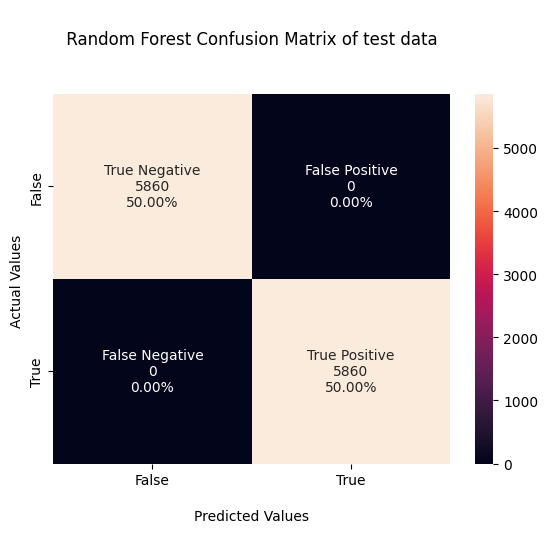


Evaluation on holdout test set:
Accuracy : 1.00000
Precision : 1.00000
Recall : 1.00000
F1 Score : 1.00000

 Random Forest Confusion Matrix on test data:
[[5860    0]
 [   0 5860]]

 Random Forest Classification Report on test data:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      5860
     Malware       1.00      1.00      1.00      5860

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720

Prediction Time (Test Data): 0.000003072 seconds


In [13]:
#RandomForest Classifier
model = RandomForestClassifier(random_state=42)
model_name = 'Random Forest'

# Call the evaluation function
evaluate_classifier_with_metrics(X, Y,model, model_name, cv_folds=10)

Cross-Validation Report
Result For each fold:
Accuracy  - [0.9996587030716724, 0.9998293515358362, 0.9996587030716724, 1.0, 0.9998293515358362, 0.9996587030716724, 1.0, 1.0, 1.0, 1.0]
Precision - [0.9996589358799454, 0.9998294097577619, 0.9996587030716724, 1.0, 0.9998294097577619, 0.9996587030716724, 1.0, 1.0, 1.0, 1.0]
Recall  - [0.9996587030716724, 0.9998293515358362, 0.9996587030716724, 1.0, 0.9998293515358362, 0.9996587030716724, 1.0, 1.0, 1.0, 1.0]
F1-Score - [0.9996587030319168, 0.9998293515308668, 0.9996587030716724, 1.0, 0.9998293515308668, 0.9996587030716724, 1.0, 1.0, 1.0, 1.0]
Average Scores:
 Accuracy : 0.9998634812286691
 Precision : 0.9998635161538815
 Recall : 0.9998634812286691
 F1-Score : 0.9998634812236995


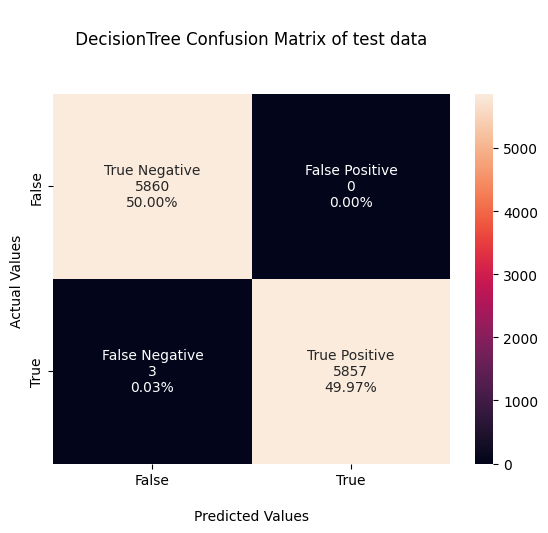


Evaluation on heldout test set:
Accuracy : 0.99974
Precision : 0.99974
Recall : 0.99974
F1 Score : 0.99974

 DecisionTree Confusion Matrix on test data:
[[5860    0]
 [   3 5857]]

 DecisionTree Classification Report on test data:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      5860
     Malware       1.00      1.00      1.00      5860

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720

Prediction Time (Test Data): 0.000000172 seconds


In [17]:
#DecisionTree Classifier
model = DecisionTreeClassifier()
model_name = 'DecisionTree'

# Call the evaluation function
evaluate_classifier_with_metrics(X, Y, model, model_name, cv_folds=10)

Cross-Validation Report
Result For each fold:
Accuracy  - [1.0, 0.9996587030716724, 0.9993174061433447, 0.9988054607508532, 0.9996587030716724, 0.9994880546075086, 0.9994879672299027, 0.9996586448199352, 0.9998293224099676, 1.0]
Precision - [1.0, 0.9996589358799454, 0.9993174061433447, 0.9988083077970719, 0.9996587030716724, 0.9994881127896788, 0.9994884911379212, 0.9996588777473867, 0.9998293806418305, 1.0]
Recall  - [1.0, 0.9996587030716724, 0.9993174061433447, 0.9988054607508532, 0.9996587030716724, 0.9994880546075086, 0.9994879672299027, 0.9996586448199352, 0.9998293224099676, 1.0]
F1-Score - [1.0, 0.9996587030319168, 0.9993174061433447, 0.9988054590463341, 0.9996587030716724, 0.9994880545926003, 0.9994879671404071, 0.9996586448000473, 0.9998293224000236, 1.0]
Average Scores:
 Accuracy : 0.9995904262104857
 Precision : 0.9995908215208852
 Recall : 0.9995904262104857
 F1-Score : 0.9995904260226347


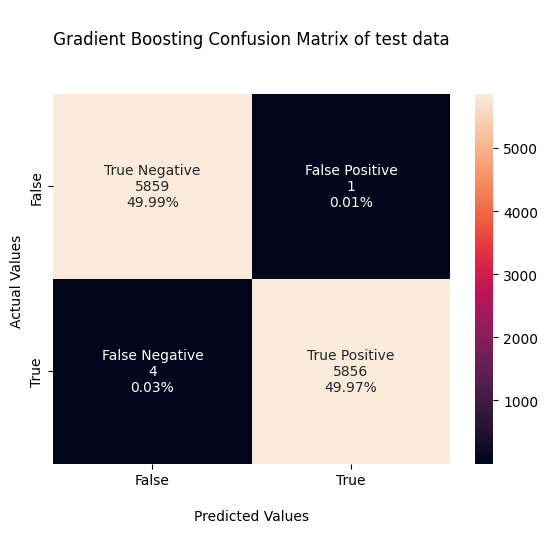


Evaluation on heldout test set:
Accuracy : 0.99957
Precision : 0.99957
Recall : 0.99957
F1 Score : 0.99957

 Gradient Boosting Confusion Matrix on test data:
[[5859    1]
 [   4 5856]]

 Gradient Boosting Classification Report on test data:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      5860
     Malware       1.00      1.00      1.00      5860

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720

Prediction Time (Test Data): 0.000004249 seconds


In [18]:
#GradientBoosting Classifier
model = GradientBoostingClassifier()
model_name = 'Gradient Boosting'

# Call the evaluation function
evaluate_classifier_with_metrics(X, Y, model, model_name, cv_folds=10)

Cross-Validation Report
Result For each fold:
Accuracy  - [0.9986348122866894, 0.9988054607508532, 0.9967576791808874, 0.9962457337883959, 0.9979522184300341, 0.9964163822525597, 0.9977811913295784, 0.9981225465096433, 0.9977811913295784, 0.9982932240996757]
Precision - [0.9986357416128162, 0.9988059836752732, 0.9967591257880867, 0.9962459650064485, 0.9979524504431969, 0.9964233790992172, 0.997781249461988, 0.9981226044431872, 0.9977817137460013, 0.9982934565498168]
Recall  - [0.9986348122866894, 0.9988054607508532, 0.9967576791808874, 0.9962457337883959, 0.9979522184300341, 0.9964163822525597, 0.9977811913295784, 0.9981225465096433, 0.9977811913295784, 0.9982932240996757]
F1-Score - [0.9986348116506012, 0.9988054604377787, 0.9967576768204033, 0.9962457333510853, 0.9979522181915012, 0.9964163696251769, 0.9977811913295784, 0.9981225464002598, 0.9977811909417638, 0.9982932240002361]
Average Scores:
 Accuracy : 0.9976790439957895
 Precision : 0.9976801669826031
 Recall : 0.997679043995789

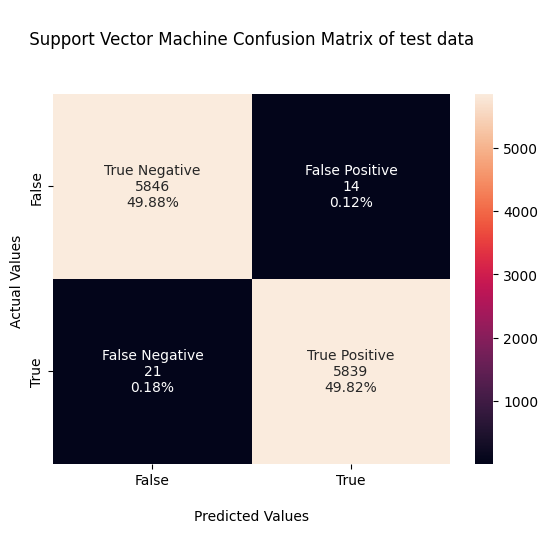


Evaluation on heldout test set:
Accuracy : 0.99701
Precision : 0.99701
Recall : 0.99701
F1 Score : 0.99701

 Support Vector Machine Confusion Matrix on test data:
[[5846   14]
 [  21 5839]]

 Support Vector Machine Classification Report on test data:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      5860
     Malware       1.00      1.00      1.00      5860

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720

Prediction Time (Test Data): 0.000098084 seconds


In [19]:
#SupportVectorMachine Classifier
model = SVC()
model_name = 'Support Vector Machine'

# Call the evaluation function
evaluate_classifier_with_metrics(X, Y, model, model_name, cv_folds=10)

Cross-Validation Report
Result For each fold:
Accuracy  - [0.9967576791808874, 0.9972696245733789, 0.9948805460750854, 0.9964163822525597, 0.9964163822525597, 0.9953924914675768, 0.9969278033794163, 0.9962450930192865, 0.9960744154292541, 0.9965864481993514]
Precision - [0.9967674584095879, 0.9972698562684975, 0.9948888471611772, 0.9964164400769304, 0.9964164400769304, 0.9953953190334929, 0.996933592033549, 0.9962453238785007, 0.9960772494527862, 0.9965922366411124]
Recall  - [0.9967576791808874, 0.9972696245733789, 0.9948805460750854, 0.9964163822525597, 0.9964163822525597, 0.9953924914675768, 0.9969278033794163, 0.9962450930192865, 0.9960744154292541, 0.9965864481993514]
F1-Score - [0.996757663223948, 0.9972696242553349, 0.9948805246070294, 0.9964163821482016, 0.9964163821482016, 0.9953924848930029, 0.9969277935348582, 0.9962450923629849, 0.996074410626315, 0.9965864392497636]
Average Scores:
 Accuracy : 0.9962966865829357
 Precision : 0.9963002763032565
 Recall : 0.9962966865829357


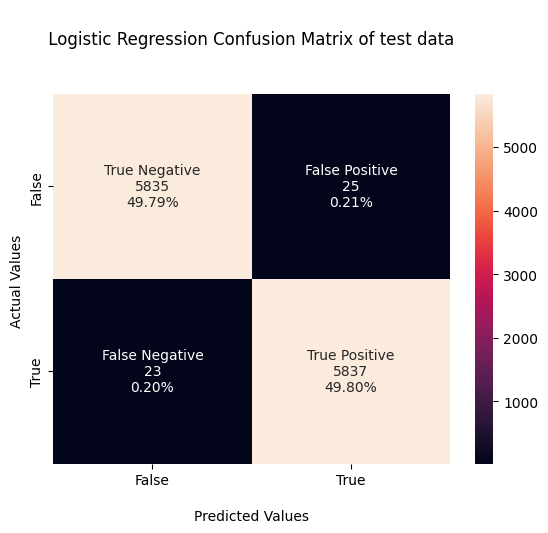


Evaluation on heldout test set:
Accuracy : 0.99590
Precision : 0.99590
Recall : 0.99590
F1 Score : 0.99590

 Logistic Regression Confusion Matrix on test data:
[[5835   25]
 [  23 5837]]

 Logistic Regression Classification Report on test data:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      5860
     Malware       1.00      1.00      1.00      5860

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720

Prediction Time (Test Data): 0.000000000 seconds


In [20]:
#LogisticRegression Classifier
model = LogisticRegression()
model_name = 'Logistic Regression'

# Call the evaluation function
evaluate_classifier_with_metrics(X, Y, model, model_name, cv_folds=10)

Cross-Validation Report
Result For each fold:
Accuracy  - [0.9938566552901024, 0.9935153583617747, 0.9907849829351536, 0.9928327645051195, 0.9916382252559727, 0.9931740614334471, 0.9936849291688001, 0.9918074756784434, 0.9926608636286056, 0.9931728963987029]
Precision - [0.9939017599482579, 0.9935431833685601, 0.9908236318157588, 0.9928385052651196, 0.9916863921834647, 0.9931823338951044, 0.9937056899213248, 0.9918303900779433, 0.992686190114123, 0.99320600858524]
Recall  - [0.9938566552901024, 0.9935153583617747, 0.9907849829351536, 0.9928327645051195, 0.9916382252559727, 0.9931740614334471, 0.9936849291688001, 0.9918074756784434, 0.9926608636286056, 0.9931728963987029]
F1-Score - [0.9938565150295223, 0.9935152669626091, 0.9907848015272698, 0.9928327436334251, 0.9916380204654456, 0.9931740328093723, 0.9936848592619253, 0.9918073754420081, 0.9926607738335731, 0.9931727866156592]
Average Scores:
 Accuracy : 0.9927128212656122
 Precision : 0.9927404085174896
 Recall : 0.9927128212656122


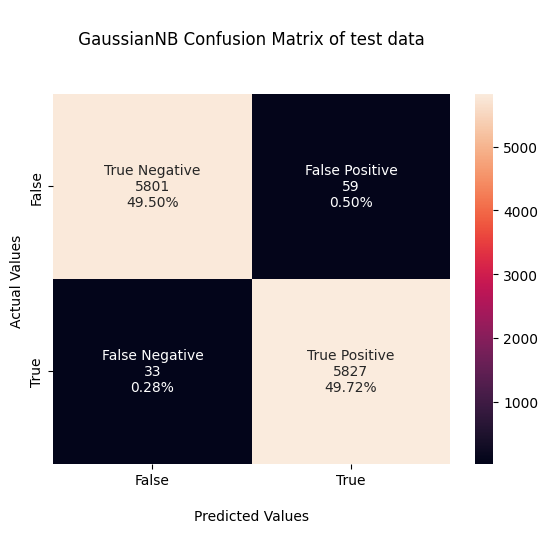


Evaluation on heldout test set:
Accuracy : 0.99215
Precision : 0.99216
Recall : 0.99215
F1 Score : 0.99215

 GaussianNB Confusion Matrix on test data:
[[5801   59]
 [  33 5827]]

 GaussianNB Classification Report on test data:
              precision    recall  f1-score   support

      Benign       0.99      0.99      0.99      5860
     Malware       0.99      0.99      0.99      5860

    accuracy                           0.99     11720
   macro avg       0.99      0.99      0.99     11720
weighted avg       0.99      0.99      0.99     11720

Prediction Time (Test Data): 0.000002186 seconds


In [22]:
#GaussianNaiveBayes Classifier
model = GaussianNB()
model_name = 'GaussianNB'

# Call the evaluation function
evaluate_classifier_with_metrics(X, Y, model, model_name, cv_folds=10)

Cross-Validation Report
Result For each fold:
Accuracy  - [0.9996587030716724, 1.0, 0.9993174061433447, 0.9998293515358362, 0.9994880546075086, 0.9996587030716724, 0.9996586448199352, 0.9998293224099676, 0.9994879672299027, 0.9998293224099676]
Precision - [0.9996589358799454, 1.0, 0.9993174061433447, 0.9998294097577619, 0.9994881127896788, 0.9996589358799454, 0.9996588776679434, 0.9998293806617049, 0.9994884909592959, 0.9998293806418305]
Recall  - [0.9996587030716724, 1.0, 0.9993174061433447, 0.9998293515358362, 0.9994880546075086, 0.9996587030716724, 0.9996586448199352, 0.9998293224099676, 0.9994879672299027, 0.9998293224099676]
F1-Score - [0.9996587030319168, 1.0, 0.9993174061433447, 0.9998293515308668, 0.9994880545926003, 0.9996587030319168, 0.9996586447602714, 0.9998293224099676, 0.9994879670509113, 0.9998293224000236]
Average Scores:
 Accuracy : 0.9996757475299807
 Precision : 0.9996758930381452
 Recall : 0.9996757475299807
 F1-Score : 0.9996757474951818


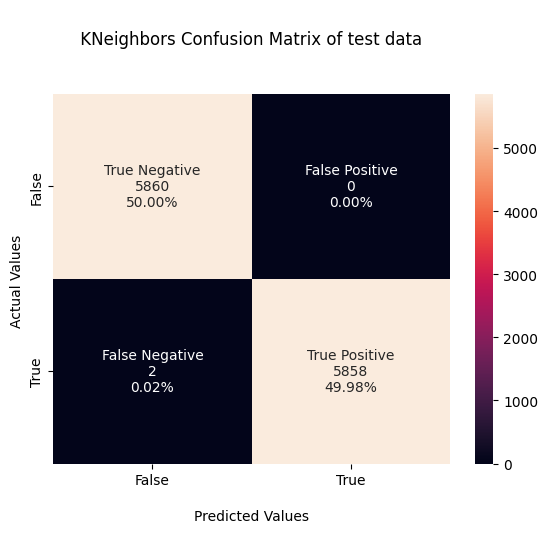


Evaluation on heldout test set:
Accuracy : 0.99983
Precision : 0.99983
Recall : 0.99983
F1 Score : 0.99983

 KNeighbors Confusion Matrix on test data:
[[5860    0]
 [   2 5858]]

 KNeighbors Classification Report on test data:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      5860
     Malware       1.00      1.00      1.00      5860

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720

Prediction Time (Test Data): 0.000249109 seconds


In [23]:
#K-NearestNeighbour Classifier
model = KNeighborsClassifier()
model_name = 'KNeighbors'

# Call the evaluation function
evaluate_classifier_with_metrics(X, Y, model, model_name, cv_folds=10)

Cross-Validation Report
Result For each fold:
Accuracy  - [0.9998293515358362, 1.0, 0.9996587030716724, 1.0, 0.9998293515358362, 1.0, 1.0, 1.0, 1.0, 1.0]
Precision - [0.9998294097577619, 1.0, 0.9996589358799454, 1.0, 0.9998294097577619, 1.0, 1.0, 1.0, 1.0, 1.0]
Recall  - [0.9998293515358362, 1.0, 0.9996587030716724, 1.0, 0.9998293515358362, 1.0, 1.0, 1.0, 1.0, 1.0]
F1-Score - [0.9998293515308668, 1.0, 0.9996587030319168, 1.0, 0.9998293515308668, 1.0, 1.0, 1.0, 1.0, 1.0]
Average Scores:
 Accuracy : 0.9999317406143344
 Precision : 0.999931775539547
 Recall : 0.9999317406143344
 F1-Score : 0.9999317406093651


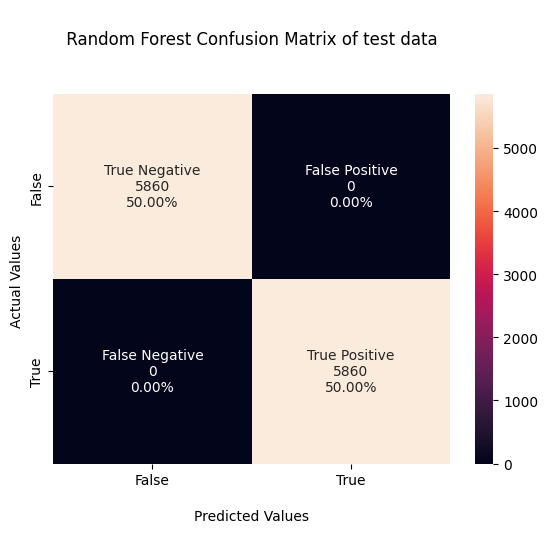


Evaluation on heldout test set:
Accuracy : 1.00000
Precision : 1.00000
Recall : 1.00000
F1 Score : 1.00000

 Random Forest Confusion Matrix on test data:
[[5860    0]
 [   0 5860]]

 Random Forest Classification Report on test data:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      5860
     Malware       1.00      1.00      1.00      5860

    accuracy                           1.00     11720
   macro avg       1.00      1.00      1.00     11720
weighted avg       1.00      1.00      1.00     11720

Prediction Time (Test Data): 0.000002711 seconds


By Comparing all these results from Baseline classification , 'Random Forest classifier' proved to be a bestfit for the Malware Detection System.


In [24]:
# Result for RandomForest Classifier
model = RandomForestClassifier(random_state=42)
model_name = 'Random Forest'

# Call the evaluation function
evaluate_classifier_with_metrics(X, Y,model, model_name, cv_folds=10)
print(f"\n\nBy Comparing all these results from Baseline classification , '{model_name} classifier' proved to be a bestfit for the Malware Detection System.")

In [67]:
### Create a DataFrame to compare the accuracy of each Classifier  model
classifier = [
    'Random Forest','Decision tree','Gradient Boosting','Support Vector Machine','K-Nearest Neighbour','Logistic Regression' ,'Naive Bayes'
]
Accuracy = [
   1.0000,0.99974,0.99957,0.99701,0.99983,0.99590,0.99215
]
Precision = [
   1.0000,0.99974,0.99957,0.99701,0.99983,0.99590,0.99215
]
recall = [
   1.0000,0.99974,0.99957,0.99701,0.99983,0.99590,0.99215
]
f1_score = [
   1.0000,0.99974,0.99957,0.99701,0.99983,0.99590,0.99215
]

classifier_compar_df = pd.DataFrame({
    'Classifier': classifier,
    'Accuracy': Accuracy,
    'Precision':Precision,
    'Recall' :recall,
    'F1-Score':f1_score
})
classifier_compar_df = classifier_compar_df.sort_values(by=['Accuracy','Precision','Recall','F1-Score'], ascending=[False,False,False,False])
classifier_compar_df.reset_index(drop=True,inplace=True)
classifier_compar_df.index += 1 
# Display the DataFrame
classifier_compar_df

Classifier  Accuracy  Precision   Recall  F1-Score
1           Random Forest   1.00000    1.00000  1.00000   1.00000
2     K-Nearest Neighbour   0.99983    0.99983  0.99983   0.99983
3           Decision tree   0.99974    0.99974  0.99974   0.99974
4       Gradient Boosting   0.99957    0.99957  0.99957   0.99957
5  Support Vector Machine   0.99701    0.99701  0.99701   0.99701
6     Logistic Regression   0.99590    0.99590  0.99590   0.99590
7             Naive Bayes   0.99215    0.99215  0.99215   0.99215

In [68]:
model_name = 'Random Forest'
print(f"By Comparing all these results from Baseline classification ,\n'{model_name} classifier' proved to be a bestfit for the Malware Detection System.")

By Comparing all these results from Baseline classification ,
'Random Forest classifier' proved to be a bestfit for the Malware Detection System.


Module 2 - Adaptive Malware Detection (Unseen malware)

In [21]:
def feature_importance_all(model, df):
    mal_subtype_label_dict = {
        'Zeus': 1.1,
        'Emotet': 1.2,
        'Refroso': 1.3,
        'Scar': 1.4,
        'Reconyc': 1.5,
        '180Solutions': 2.1,
        'Coolwebsearch': 2.2,
        'Gator': 2.3,
        'Transponder': 2.4,
        'TIBS': 2.5,
        'Conti': 3.1,
        'MAZE': 3.2,
        'Pysa': 3.3,
        'Ako': 3.4,
        'Shade': 3.5
    }
    
    # Create an empty DataFrame to store the results
    feature_df = pd.DataFrame(columns=['Malware_Subtype', 'Feature', 'Importance'])

    for malware_sub in mal_subtype_label_dict.keys():
        malware_subtype_label = mal_subtype_label_dict[malware_sub]
    
        # From df, create a dataset "df_train" that contains only the chosen malware subtype
        df_selected_subtype = df[df['Malware_subtype'] == malware_subtype_label]

        # Calculate the number of rows to copy (80% of the selected subtype)
        percentage_to_copy = 0.8
        num_rows_to_copy = int(len(df_selected_subtype) * percentage_to_copy)
        # Shuffle the data to ensure randomness
        df_selected_subtype = df_selected_subtype.sample(frac=1, random_state=1)
        # Copy the first 80% of rows with the chosen malware subtype into df_train
        df_train = df_selected_subtype.head(num_rows_to_copy)

        # Include the remaining 20% of rows with the chosen malware subtype in df_to_predict
        df_to_predict = df_selected_subtype.tail(len(df_selected_subtype) - num_rows_to_copy)

        # Create a dataset "df_remaining" that contains all other data
        df_remaining = df[df['Malware_subtype'] != malware_subtype_label]

        # Combine df_to_predict with df_remaining to form the final df_to_predict dataframe
        df_to_predict = pd.concat([df_to_predict, df_remaining])

        ### Extract the indexes of a sample of benign data from df_to_predict that matches the number of Pysa malware in df_train. 
        ### This will be used to create a new dataset "df_train" that contains both Pysa malware and benign data.

        benign_index = df_to_predict[df_to_predict['Malware_type'] == 0].sample(n=len(df_train), random_state=1).index

        # Add the sampled benign cases to df_train
        df_train = pd.concat([df_train, df_to_predict.loc[benign_index]])

        # Remove the sampled benign cases from df_to_predict
        df_to_predict = df_to_predict.drop(benign_index)

        X = df_train.drop(['Category', 'pslist.nprocs64bit', 'handles.nport',
                           'svcscan.interactive_process_services', 'Class', 'Malware_type', 'Malware_subtype'], axis=1)
        Y = df_train["Class"]
        
        # Fitting the model to the data        
        model.fit(X, Y)
        
        # Get the feature importances
        importance = model.feature_importances_

        # Select the top 5 features
        top_5_features = np.argsort(importance)[-5:]

        # Create a DataFrame for selected features and their importance
        sub_feature_df = pd.DataFrame({'Malware_Subtype': malware_sub,
                                       'Feature': X.columns[top_5_features],
                                       'Importance': importance[top_5_features]})
        
        # Append the results to the main feature_df
        # Only concat if sub_feature_df is not empty or all-NA
        if not sub_feature_df.empty and not sub_feature_df.isna().all().all():
            feature_df = pd.concat([feature_df, sub_feature_df], ignore_index=True)
            #feature_df = pd.concat([feature_df, sub_feature_df], ignore_index=True)

    # Sort the DataFrame by Malware_Subtype and Importance
    feature_df = feature_df.sort_values(by=['Malware_Subtype', 'Importance'], ascending=[False, True])
    return feature_df
    

model=RandomForestClassifier(random_state=0)
selected_features_df = feature_importance_all(model, df)
selected_features_df

C:\Users\R_A\AppData\Local\Temp\ipykernel_18220\2667471819.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_df = pd.concat([feature_df, sub_feature_df], ignore_index=True)


Malware_Subtype                          Feature  Importance
0     Transponder                  handles.nmutant    0.075656
1     Transponder                   handles.nevent    0.076960
2     Transponder  svcscan.shared_process_services    0.096634
3     Transponder     handles.avg_handles_per_proc    0.110509
4     Transponder                svcscan.nservices    0.137025

In [15]:
# Calculate the frequency of each feature
feature_frequencies = selected_features_df['Feature'].value_counts()

# Convert the result to a DataFrame for better presentation
feature_frequencies_df = pd.DataFrame({'Feature': feature_frequencies.index, 'Frequency': feature_frequencies.values})
feature_frequencies_df= feature_frequencies_df.sort_values(by=['Feature', 'Frequency'], ascending=[False, False])

# Print the DataFrame sorted by frequency
feature_frequencies_df

Feature  Frequency
1  svcscan.shared_process_services         15
0                svcscan.nservices         15
2           svcscan.kernel_drivers          9
3              pslist.avg_handlers          8
8                 handles.nsection          3
5                  handles.nmutant          6
7                 handles.nhandles          4
4                   handles.nevent          6
6     handles.avg_handles_per_proc          6
9        dlllist.avg_dlls_per_proc          3

In [16]:
def feature_importance(model,malware_sub):

        mal_subtype_label_dict = {
        'Benign': 0,
        'Zeus': 1.1,
        'Emotet': 1.2,
        'Refroso': 1.3,
        'Scar': 1.4,
        'Reconyc': 1.5,
        '180Solutions': 2.1,
        'Coolwebsearch': 2.2,
        'Gator': 2.3,
        'Transponder': 2.4,
        'TIBS': 2.5,
        'Conti': 3.1,
        'MAZE': 3.2,
        'Pysa': 3.3,
        'Ako': 3.4,
        'Shade': 3.5
    }
        malware_subtype_label = mal_subtype_label_dict[malware_sub]

        # From df, create a dataset "df_train" that contains only the chosen malware subtype
        df_selected_subtype = df[df['Malware_subtype'] == malware_subtype_label]

        # Calculate the number of rows to copy (80% of the selected subtype)
        percentage_to_copy = 0.8
        num_rows_to_copy = int(len(df_selected_subtype) * percentage_to_copy)
        # Shuffle the data to ensure randomness
        df_selected_subtype = df_selected_subtype.sample(frac=1, random_state=1)
        # Copy the first 80% of rows with the chosen malware subtype into df_train
        df_train = df_selected_subtype.head(num_rows_to_copy)

        # Include the remaining 20% of rows with the chosen malware subtype in df_to_predict
        df_to_predict = df_selected_subtype.tail(len(df_selected_subtype) - num_rows_to_copy)

        # Create a dataset "df_remaining" that contains all other data
        df_remaining = df[df['Malware_subtype'] != malware_subtype_label]

        # Combine df_to_predict with df_remaining to form the final df_to_predict dataframe
        df_to_predict = pd.concat([df_to_predict, df_remaining])

        benign_index = df_to_predict[df_to_predict['Malware_type'] == 0].sample(n=len(df_train), random_state=1).index

        # Add the sampled benign cases to df_train
        df_train = pd.concat([df_train, df_to_predict.loc[benign_index]])

        # Remove the sampled benign cases from df_to_predict
        df_to_predict = df_to_predict.drop(benign_index)

        X = df_train.drop(['Category', 'pslist.nprocs64bit', 'handles.nport',
                           'svcscan.interactive_process_services', 'Class', 'Malware_type', 'Malware_subtype'], axis=1)
        Y = df_train["Class"]

        # Fitting the model to the data 
        model.fit(X, Y)

        # Get the feature importances
        importance = model.feature_importances_

        # Select the top 5 features
        top_5_features = np.argsort(importance)[-5:]

        # Create a dictionary of feature importances
        importance_dict = {X.columns.values[i]: importance[i] for i in top_5_features}

        # Sort the dictionary by importance
        sorted_dict = {k: v for k, v in sorted(importance_dict.items(), key=lambda item: item[1])}

        # Get the selected features as a list
        selected_features = list(sorted_dict.keys())[::-1]

        return selected_features

In [17]:
def train_predict_novel_malware_2(malware_sub, selected_features):
    # dictionary that maps the malware subtype to its corresponding label
    mal_type_label_dict = {
        0: 'Benign',
        1: 'Trojan',
        2: 'Spyware',
        3: 'Ransomware'
    }
    mal_subtype_label_dict = {
        'Benign': 0,
        'Zeus': 1.1,
        'Emotet': 1.2,
        'Refroso': 1.3,
        'Scar': 1.4,
        'Reconyc': 1.5,
        '180Solutions': 2.1,
        'Coolwebsearch': 2.2,
        'Gator': 2.3,
        'Transponder': 2.4,
        'TIBS': 2.5,
        'Conti': 3.1,
        'MAZE': 3.2,
        'Pysa': 3.3,
        'Ako': 3.4,
        'Shade': 3.5
    }

    ## Map malware_subtype to its corresponding label
    malware_subtype_label = mal_subtype_label_dict[malware_sub]
    
    # From df, create a dataset "df_train" that contains only the chosen malware subtype
    df_selected_subtype = df[df['Malware_subtype'] == malware_subtype_label]

    # Calculate the number of rows to copy (80% of the selected malware family)
    percentage_to_copy = 0.8
    num_rows_to_copy = int(len(df_selected_subtype) * percentage_to_copy)
    # Shuffle the data to ensure randomness
    df_selected_subtype = df_selected_subtype.sample(frac=1, random_state=1)
    # Copy the first 80% of rows with the chosen malware subtype into df_train
    df_train = df_selected_subtype.head(num_rows_to_copy)

    # Include the remaining 20% of rows with the chosen malware family in df_to_predict
    df_to_predict = df_selected_subtype.tail(len(df_selected_subtype) - num_rows_to_copy)

    # Create a dataset "df_remaining" that contains all other data
    df_remaining = df[df['Malware_subtype'] != malware_subtype_label]

    # Combine df_to_predict with df_remaining to form the final df_to_predict dataframe
    df_to_predict = pd.concat([df_to_predict, df_remaining])
    # Get benign samples to add to df_train
    benign_index = df_to_predict[df_to_predict['Malware_type'] == 0].sample(n=len(df_train), random_state=1).index

    # Add the sampled benign cases to df_train
    df_train = pd.concat([df_train, df_to_predict.loc[benign_index]])

    # Remove the sampled benign cases from df_to_predict
    df_to_predict = df_to_predict.drop(benign_index)

    X_train = df_train[selected_features]
    Y_train = df_train["Class"]
    
    # Feature scaling (optional for random forest)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=scaler.feature_names_in_)

    # Preparing the test dataset (unseen dataset)
    X_new = df_to_predict[selected_features]
    Y_new = df_to_predict["Class"]
    
    X_new_scaled = scaler.transform(X_new)
    # Convert X_new to a dataframe
    X_new_scaled = pd.DataFrame(X_new_scaled, columns = scaler.feature_names_in_)

    ### RandomForestClassifier
    rfc = RandomForestClassifier(random_state=0)
    rfc.fit(X_train_scaled, Y_train)

    # Prediction using unseen dataset RF
    prediction_times = []
    for i in range(1000):
        start_time = time.time()
        y_pred_new = rfc.predict(X_new_scaled) #X_new = X variables from unseen dataset
        prediction_time = time.time() - start_time
        prediction_times.append(prediction_time)
    print(f"Average prediction time: {np.mean(prediction_times)/len(y_pred_new)} seconds")
    print(f"Standard Deviation of Prediction Time:{np.std(prediction_times)/len(y_pred_new)} seconds")

    print(classification_report(Y_new, y_pred_new, target_names=['Benign', 'Malware'])) #Y_new = Y variables from unseen dataset

    print(f"Accuracy: {np.mean(y_pred_new == Y_new):.5f}")
    print(confusion_matrix(Y_new, y_pred_new))
    
    cm_RF=confusion_matrix(Y_new, y_pred_new)
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                    cm_RF.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cm_RF.flatten()/np.sum(cm_RF)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cm_RF, annot=labels, fmt='', cmap='rocket')

    ax.set_title(f'Random Forest Confusion Matrix: Unseen Dataset after training with only 80% of {malware_sub} with {len(X_train.columns)} Features \n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values \n');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

    # Add the predicted value to df_to_predict
    df_to_predict['Predicted'] = y_pred_new

    # Add an accuracy column to df_to_predict
    df_to_predict['Accuracy'] = np.where(df_to_predict['Predicted'] == df_to_predict['Class'], 1, 0)

    ### Make a barplort that compares the accuracy of prediction per malware type using the df_to_predict dataset
    # Compute Accuarcy per category
    Acc_per_type = df_to_predict[['Malware_type', 'Accuracy']].groupby('Malware_type')['Accuracy'].mean()
    # Create a barplot - use the real malware type names based on malware_type_label_dict
    Acc_per_type.index = Acc_per_type.index.map(mal_type_label_dict)
    #Acc_per_type.plot(kind='bar')
    #color = (0.2, 0.4, 0.6, 0.8)  # Red, Green, Blue, Alpha
    #plt.bar(df_to_predict['Predicted'], df_to_predict['Accuracy'], color=color)
    #plt.title(f"Accuracy of prediction per malware type using the {malware_sub} model")
    #plt.xlabel('Malware Type')
    #plt.ylabel("Accuracy")
    #plt.xticks(rotation=360)
    #plt.show()
    colormap = cm.get_cmap('viridis')
    
    # Normalize the accuracy values to the range [0, 1] for colormap mapping
    norm = mcolors.Normalize(vmin=0.9, vmax=1.0)
    
    # Create a list of colors based on the normalized accuracy values
    colors = [colormap(norm(value)) for value in Acc_per_type]
    
    # Create the bar plot with the corresponding colors
    fig, ax = plt.subplots(figsize=(6,4))
    bars = ax.bar(Acc_per_type.index, Acc_per_type, color=colors)
    
    # Add color bar to indicate the accuracy scale
    sm = cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Accuracy')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height+0.001, f'{height:.4f}', ha='center', va='bottom',fontweight='bold')
    # Add labels and title
    ax.set_xlabel('Malware Type')
    ax.set_ylabel('Accuracy')
    ax.set_title(f"Accuracy of prediction per malware type using the {malware_sub} model\n\n")
    plt.xticks(rotation=0)
    plt.ylim(0.0, 1.0)  # Set the y-axis limits to focus on the accuracy range
    plt.show() 

    ### Make a barplort that compares the accuracy of prediction per malware subtype using the df_to_predict dataset
    # Increase the size of the plot
    plt.figure(figsize=(25,5))
    # Compute Accuarcy per category
    Acc_per_subtype = df_to_predict[['Malware_subtype', 'Accuracy']].groupby('Malware_subtype')['Accuracy'].mean()
    # Create a barplot - use the real malware type names based on malware_type_label_dict
    # Invert the dictionary so that the numbers map to their respective names
    inv_mal_subtype_label_dict = {v: k for k, v in mal_subtype_label_dict.items()}
    Acc_per_subtype.index = Acc_per_subtype.index.map(inv_mal_subtype_label_dict)
    #Acc_per_subtype.plot(kind='bar',stacked=True)
    #plt.title(f"Accuracy of prediction per malware subtype using the {malware_sub} model")
    #plt.xlabel('Malware Subtype')
    #plt.ylabel("Accuracy")
    #plt.xticks(rotation=45)
    #plt.show()
    norm = mcolors.Normalize(vmin=0.9, vmax=1.0)
    colors = [colormap(norm(value)) for value in Acc_per_subtype]
    
    # Create the bar plot with the corresponding colors
    fig, ax = plt.subplots(figsize=(20,5))
    bars = ax.bar(Acc_per_subtype.index, Acc_per_subtype, color=colors)
    
    # Add color bar to indicate the accuracy scale
    sm = cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Accuracy')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.4f}', ha='center', va='bottom',fontweight='bold')
        #ax.text(bar.get_x() + bar.get_width()/2, height/2, f'{height:.4f}', ha='center', va='bottom',color ='black',fontsize=10,fontweight='bold')
    # Add labels and title
    ax.set_xlabel('Malware Type')
    ax.set_ylabel('Accuracy')
    ax.set_title(f"Accuracy of prediction per malware subtype using the {malware_sub} model\n\n")
    plt.xticks(rotation=90)
    plt.ylim(0.0, 1.0)  # Set the y-axis limits to focus on the accuracy range
    plt.show()
    #plot_accuracy_per_type(Acc_per_type, "Accuracy of Prediction per Malware Type")
    #plot_accuracy_per_type(Acc_per_subtype, "Accuracy of Prediction per Malware Subtype")
    return Acc_per_type, Acc_per_subtype


def plot_accuracy_per_type(Acc_per_type, title):
    # Define the colormap: 'viridis' is perceptually uniform and suitable for representing data
    colormap = matplotlib.colormaps.get_cmap('viridis')
    
    # Normalize the accuracy values to the range [0, 1] for colormap mapping
    norm = mcolors.Normalize(vmin=0.8, vmax=1.0)
    
    # Create a list of colors based on the normalized accuracy values
    colors = [colormap(norm(value)) for value in Acc_per_type]
    
    # Create the bar plot with the corresponding colors
    fig, ax = plt.subplots(figsize=(10,7))
    bars = ax.bar(Acc_per_type.index, Acc_per_type, color=colors)
    
    # Add color bar to indicate the accuracy scale
    sm = cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Accuracy')
    
    # Add labels and title
    ax.set_xlabel('Malware Type')
    ax.set_ylabel('Accuracy')
    ax.set_title(f"Accuracy of prediction per malware subtype using the {malware_sub} model")
    plt.xticks(rotation=90)
    plt.ylim(0.5, 1.0)  # Set the y-axis limits to focus on the accuracy range
    plt.show()   


['pslist.avg_handlers', 'handles.avg_handles_per_proc', 'svcscan.nservices', 'svcscan.shared_process_services', 'handles.nhandles']
Average prediction time: 2.4786514214426225e-06 seconds
Standard Deviation of Prediction Time:1.337062759840635e-06 seconds
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98     27738
     Malware       1.00      0.96      0.98     27738

    accuracy                           0.98     55476
   macro avg       0.98      0.98      0.98     55476
weighted avg       0.98      0.98      0.98     55476

Accuracy: 0.97996
[[27716    22]
 [ 1090 26648]]


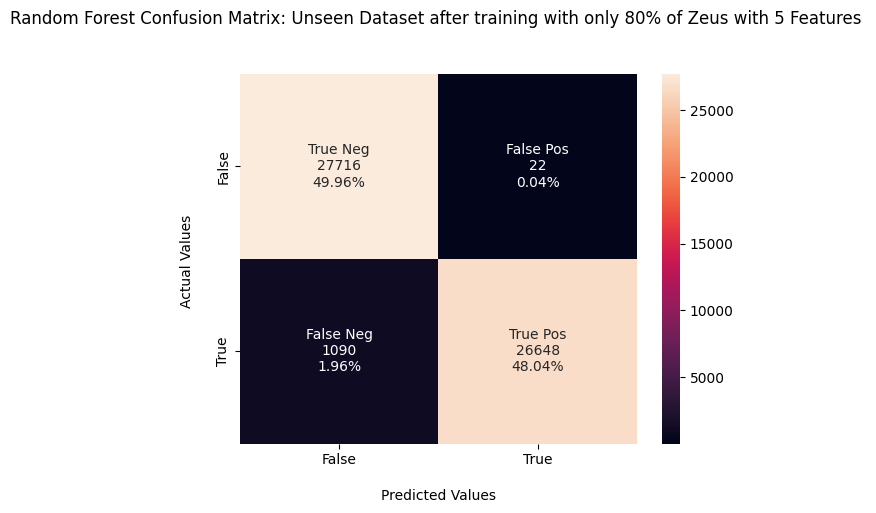

C:\Users\R_A\AppData\Local\Temp\ipykernel_9596\1550231141.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


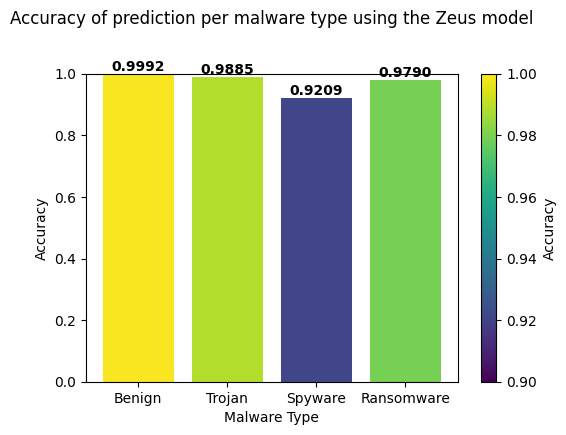

<Figure size 2500x500 with 0 Axes>

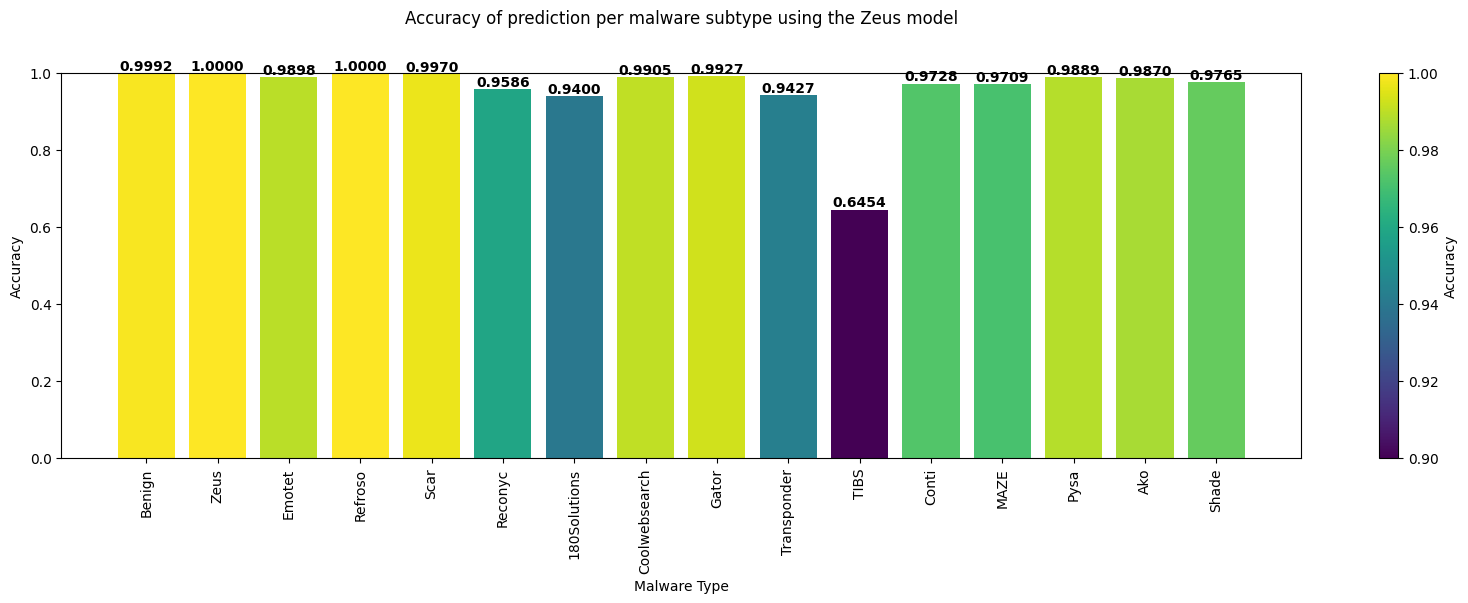

(Malware_type
 Benign        0.999207
 Trojan        0.988520
 Spyware       0.920858
 Ransomware    0.978960
 Name: Accuracy, dtype: float64,
 Malware_subtype
 Benign           0.999207
 Zeus             1.000000
 Emotet           0.989832
 Refroso          1.000000
 Scar             0.997000
 Reconyc          0.958599
 180Solutions     0.940000
 Coolwebsearch    0.990500
 Gator            0.992727
 Transponder      0.942739
 TIBS             0.645390
 Conti            0.972837
 MAZE             0.970889
 Pysa             0.988934
 Ako              0.987000
 Shade            0.976504
 Name: Accuracy, dtype: float64)

In [71]:
#Zeus Subtype
malware_sub='Zeus'
model= RandomForestClassifier(random_state=0)
selected_features=feature_importance(model, malware_sub)
print(selected_features)
train_predict_novel_malware_2(malware_sub, selected_features)

['svcscan.nservices', 'svcscan.shared_process_services', 'svcscan.kernel_drivers', 'pslist.avg_handlers', 'handles.nsection']
Average prediction time: 1.9449380456702572e-06 seconds
Standard Deviation of Prediction Time:2.606392205392042e-07 seconds
              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99     27725
     Malware       1.00      0.98      0.99     27725

    accuracy                           0.99     55450
   macro avg       0.99      0.99      0.99     55450
weighted avg       0.99      0.99      0.99     55450

Accuracy: 0.99066
[[27664    61]
 [  457 27268]]


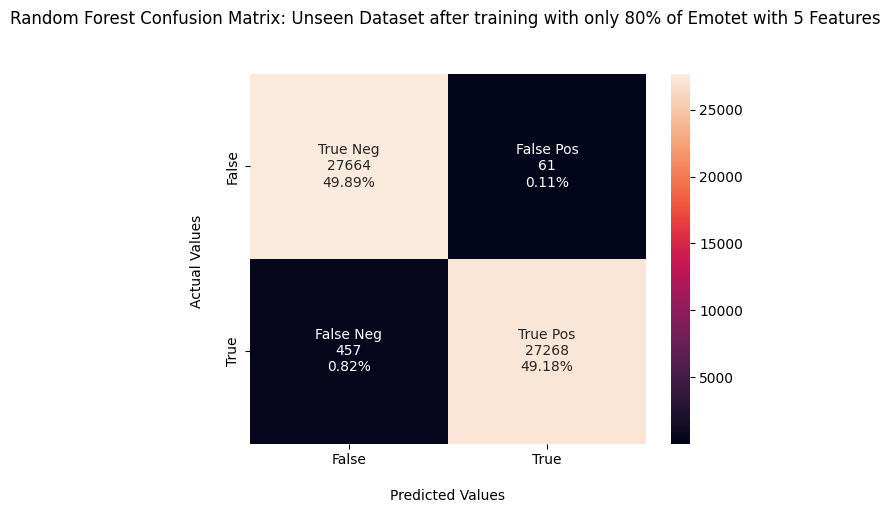

C:\Users\R_A\AppData\Local\Temp\ipykernel_9596\3695053275.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


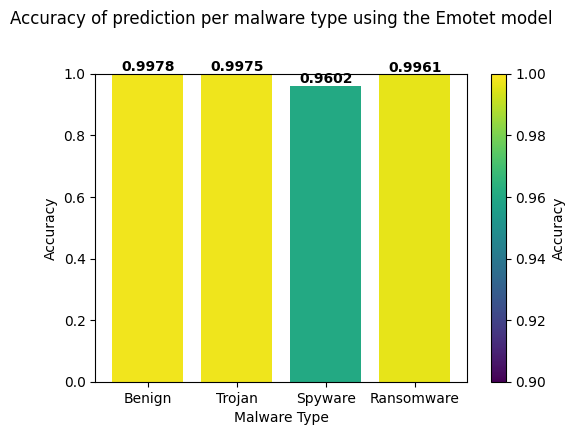

<Figure size 2500x500 with 0 Axes>

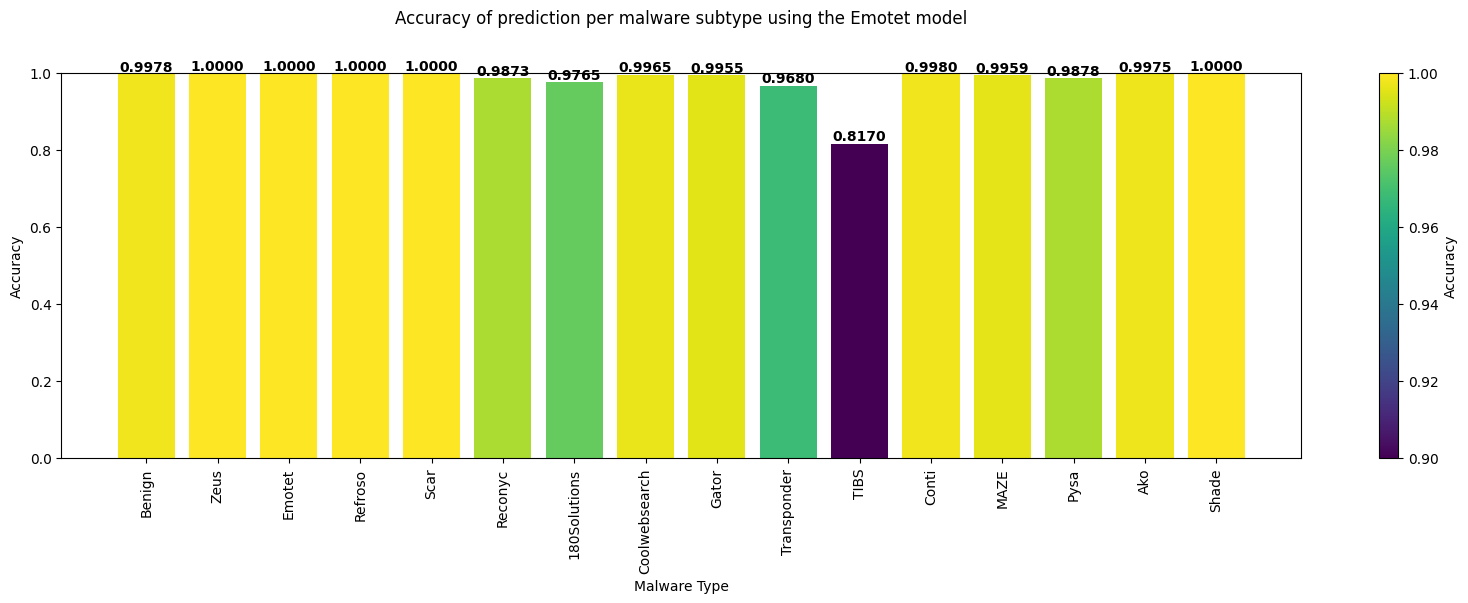

(Malware_type
 Benign        0.997800
 Trojan        0.997473
 Spyware       0.960180
 Ransomware    0.996119
 Name: Accuracy, dtype: float64,
 Malware_subtype
 Benign           0.997800
 Zeus             1.000000
 Emotet           1.000000
 Refroso          1.000000
 Scar             1.000000
 Reconyc          0.987261
 180Solutions     0.976500
 Coolwebsearch    0.996500
 Gator            0.995455
 Transponder      0.968050
 TIBS             0.817021
 Conti            0.997988
 MAZE             0.995914
 Pysa             0.987769
 Ako              0.997500
 Shade            1.000000
 Name: Accuracy, dtype: float64)

In [68]:
#Emotet Subtype
malware_sub='Emotet'
model= RandomForestClassifier(random_state=0)
selected_features=feature_importance(model, malware_sub)
print(selected_features)
train_predict_novel_malware_2(malware_sub, selected_features)

['handles.avg_handles_per_proc', 'pslist.avg_handlers', 'svcscan.nservices', 'svcscan.shared_process_services', 'dlllist.avg_dlls_per_proc']
Average prediction time: 2.263988352947798e-06 seconds
Standard Deviation of Prediction Time:1.3845855986707223e-06 seconds
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98     27698
     Malware       1.00      0.96      0.98     27698

    accuracy                           0.98     55396
   macro avg       0.98      0.98      0.98     55396
weighted avg       0.98      0.98      0.98     55396

Accuracy: 0.98103
[[27679    19]
 [ 1032 26666]]


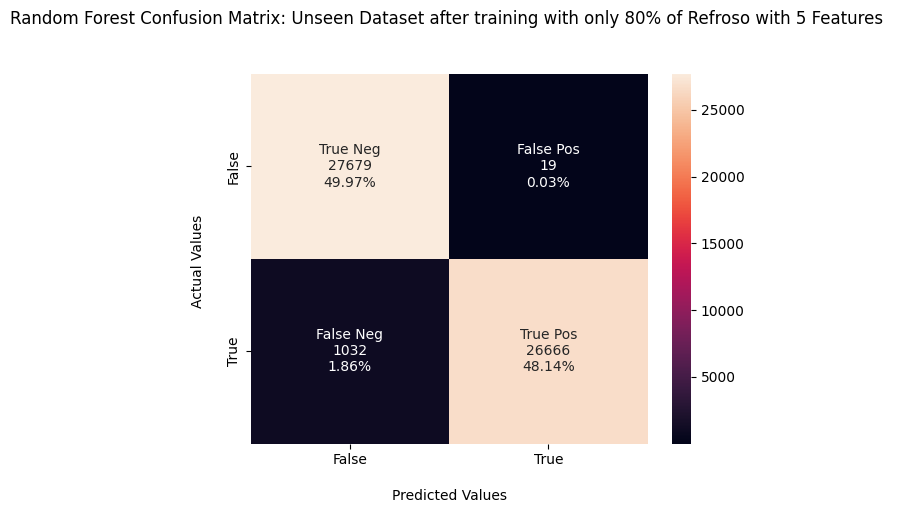

C:\Users\R_A\AppData\Local\Temp\ipykernel_9596\112659327.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


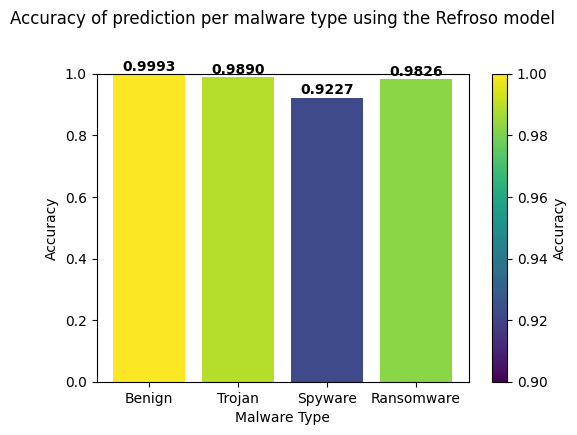

<Figure size 2500x500 with 0 Axes>

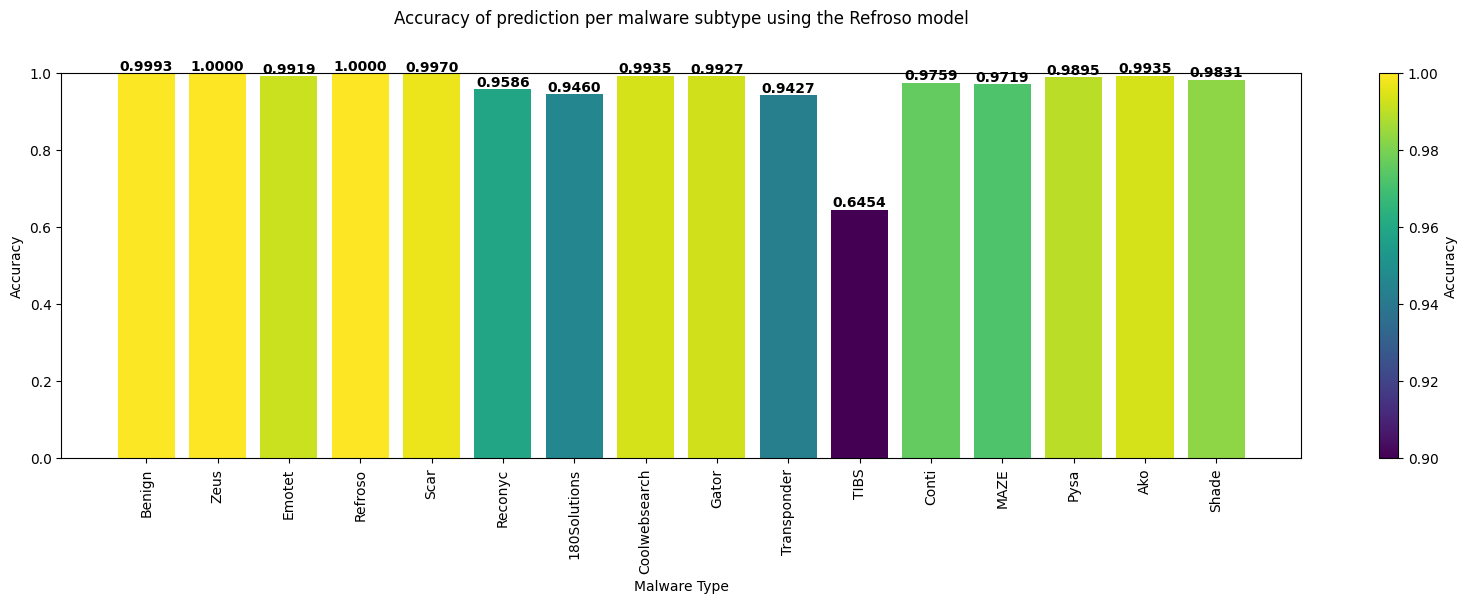

(Malware_type
 Benign        0.999314
 Trojan        0.988969
 Spyware       0.922655
 Ransomware    0.982637
 Name: Accuracy, dtype: float64,
 Malware_subtype
 Benign           0.999314
 Zeus             1.000000
 Emotet           0.991866
 Refroso          1.000000
 Scar             0.997000
 Reconyc          0.958599
 180Solutions     0.946000
 Coolwebsearch    0.993500
 Gator            0.992727
 Transponder      0.942739
 TIBS             0.645390
 Conti            0.975855
 MAZE             0.971910
 Pysa             0.989517
 Ako              0.993500
 Shade            0.983083
 Name: Accuracy, dtype: float64)

In [27]:
#Refroso Subtype
malware_sub='Refroso'
model= RandomForestClassifier(random_state=0)
selected_features=feature_importance(model, malware_sub)
print(selected_features)
train_predict_novel_malware_2(malware_sub, selected_features)

['pslist.avg_handlers', 'handles.avg_handles_per_proc', 'svcscan.nservices', 'svcscan.shared_process_services', 'handles.nhandles']
Average prediction time: 2.379011841868397e-06 seconds
Standard Deviation of Prediction Time:1.4379438193811744e-06 seconds
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98     27698
     Malware       1.00      0.96      0.98     27698

    accuracy                           0.98     55396
   macro avg       0.98      0.98      0.98     55396
weighted avg       0.98      0.98      0.98     55396

Accuracy: 0.98097
[[27665    33]
 [ 1021 26677]]


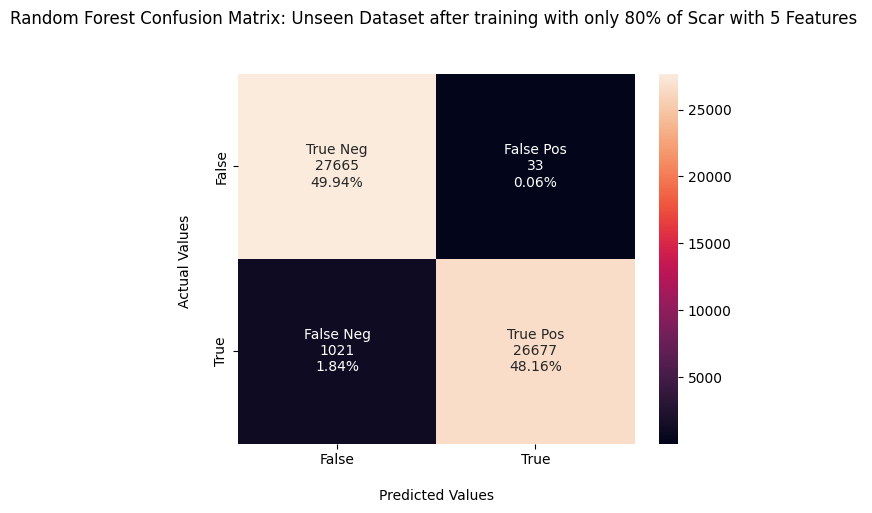

C:\Users\R_A\AppData\Local\Temp\ipykernel_9596\112659327.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


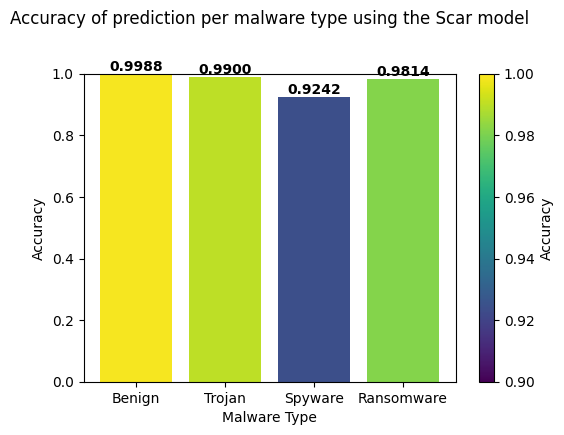

<Figure size 2500x500 with 0 Axes>

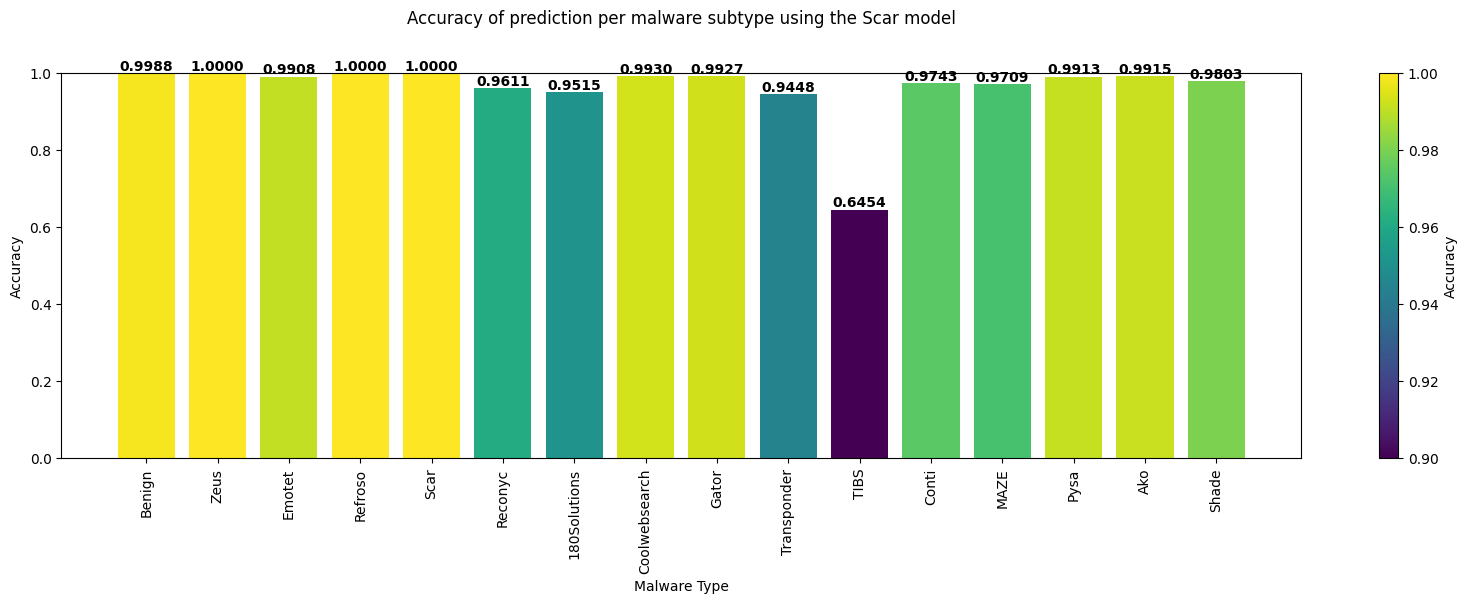

(Malware_type
 Benign        0.998809
 Trojan        0.989984
 Spyware       0.924152
 Ransomware    0.981412
 Name: Accuracy, dtype: float64,
 Malware_subtype
 Benign           0.998809
 Zeus             1.000000
 Emotet           0.990849
 Refroso          1.000000
 Scar             1.000000
 Reconyc          0.961146
 180Solutions     0.951500
 Coolwebsearch    0.993000
 Gator            0.992727
 Transponder      0.944813
 TIBS             0.645390
 Conti            0.974346
 MAZE             0.970889
 Pysa             0.991264
 Ako              0.991500
 Shade            0.980263
 Name: Accuracy, dtype: float64)

In [28]:
#Scar Subtype
malware_sub='Scar'
model= RandomForestClassifier(random_state=0)
selected_features=feature_importance(model, malware_sub)
print(selected_features)
train_predict_novel_malware_2(malware_sub, selected_features)

['svcscan.nservices', 'svcscan.shared_process_services', 'handles.nsection', 'handles.nmutant', 'svcscan.kernel_drivers']
Average prediction time: 2.4757516442789906e-06 seconds
Standard Deviation of Prediction Time:1.5237849269702355e-06 seconds
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     28042
     Malware       1.00      1.00      1.00     28042

    accuracy                           1.00     56084
   macro avg       1.00      1.00      1.00     56084
weighted avg       1.00      1.00      1.00     56084

Accuracy: 0.99670
[[27931   111]
 [   74 27968]]


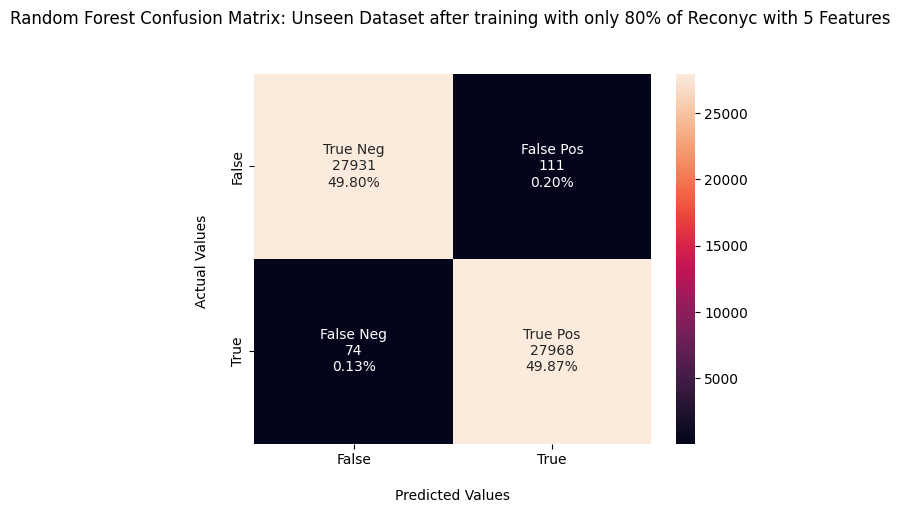

C:\Users\R_A\AppData\Local\Temp\ipykernel_9596\112659327.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


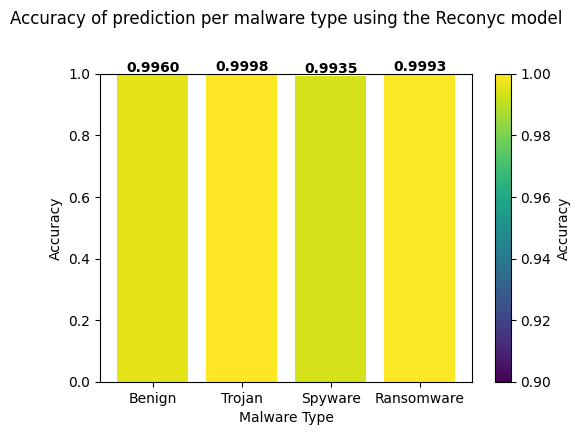

<Figure size 2500x500 with 0 Axes>

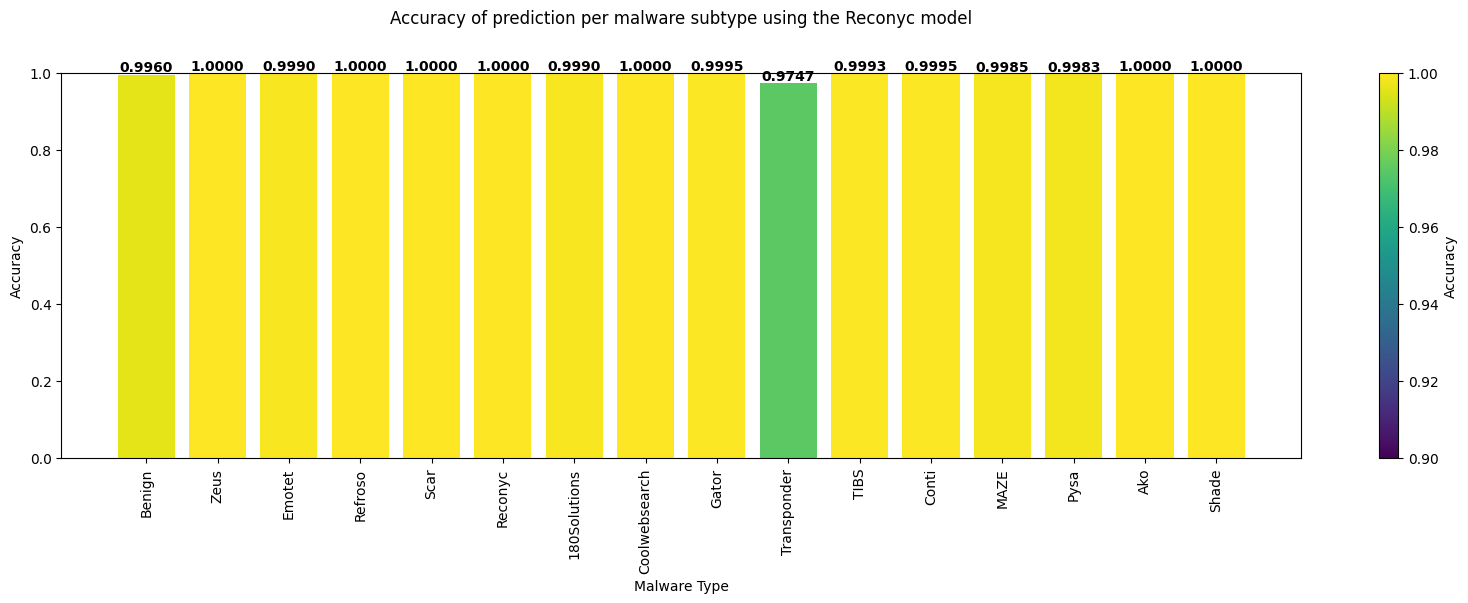

(Malware_type
 Benign        0.996042
 Trojan        0.999757
 Spyware       0.993513
 Ransomware    0.999285
 Name: Accuracy, dtype: float64,
 Malware_subtype
 Benign           0.996042
 Zeus             1.000000
 Emotet           0.998983
 Refroso          1.000000
 Scar             1.000000
 Reconyc          1.000000
 180Solutions     0.999000
 Coolwebsearch    1.000000
 Gator            0.999545
 Transponder      0.974689
 TIBS             0.999291
 Conti            0.999497
 MAZE             0.998468
 Pysa             0.998253
 Ako              1.000000
 Shade            1.000000
 Name: Accuracy, dtype: float64)

In [29]:
#Reconyc Subtype
malware_sub='Reconyc'
model= RandomForestClassifier(random_state=0)
selected_features=feature_importance(model, malware_sub)
print(selected_features)
train_predict_novel_malware_2(malware_sub, selected_features)

['svcscan.nservices', 'handles.nevent', 'svcscan.shared_process_services', 'handles.nmutant', 'svcscan.kernel_drivers']
Average prediction time: 1.8067886290700697e-06 seconds
Standard Deviation of Prediction Time:1.7127590851648277e-07 seconds
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     27698
     Malware       1.00      1.00      1.00     27698

    accuracy                           1.00     55396
   macro avg       1.00      1.00      1.00     55396
weighted avg       1.00      1.00      1.00     55396

Accuracy: 0.99718
[[27614    84]
 [   72 27626]]


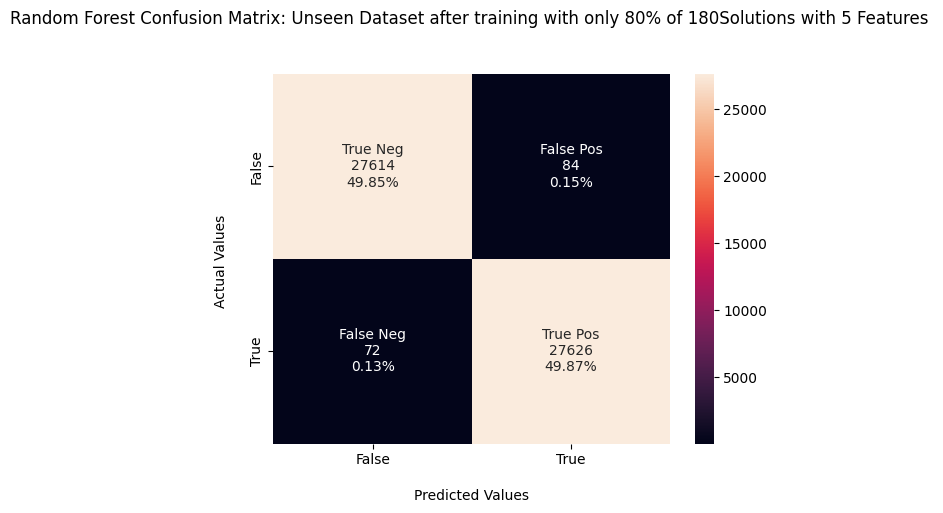

C:\Users\R_A\AppData\Local\Temp\ipykernel_9596\112659327.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


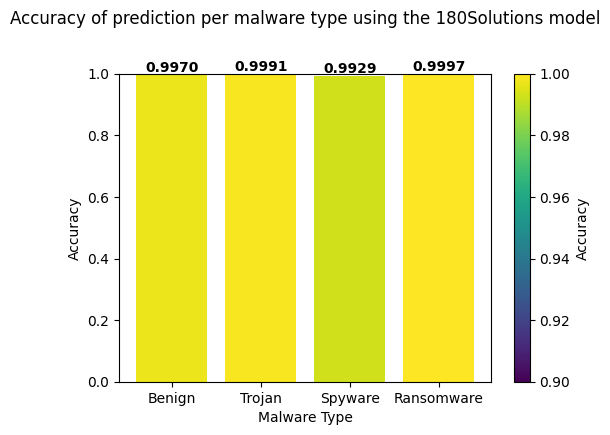

<Figure size 2500x500 with 0 Axes>

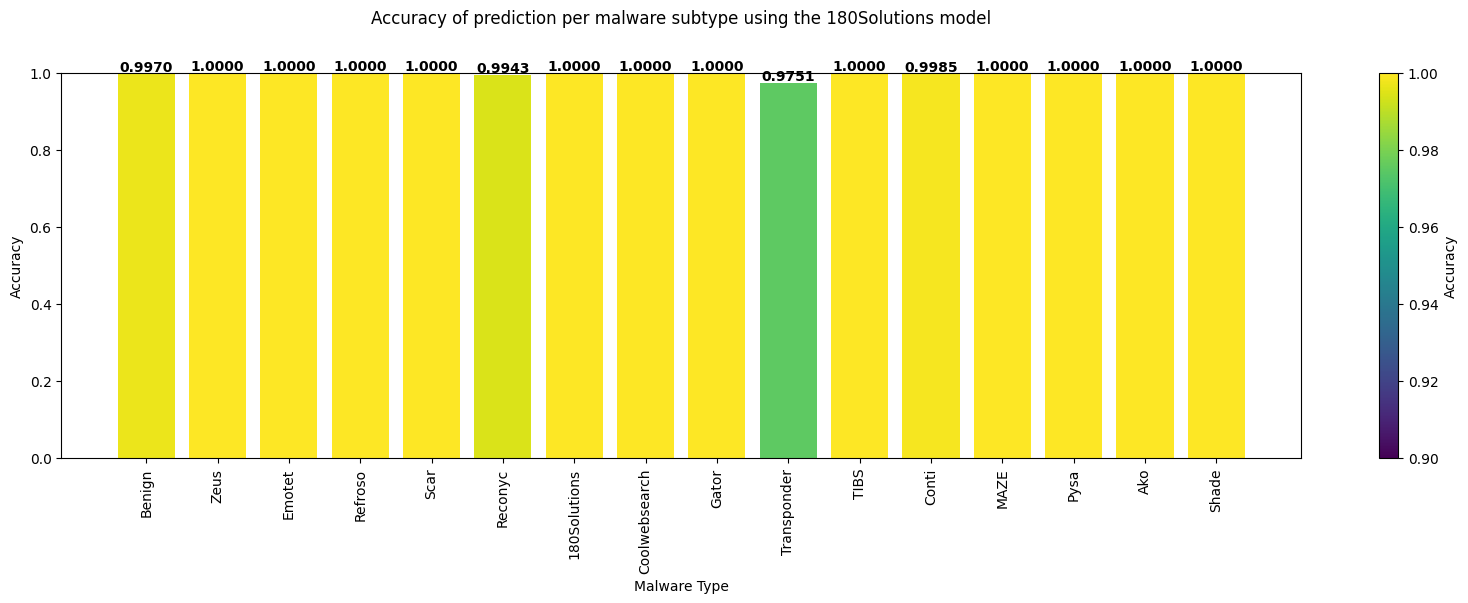

(Malware_type
 Benign        0.996967
 Trojan        0.999051
 Spyware       0.992874
 Ransomware    0.999694
 Name: Accuracy, dtype: float64,
 Malware_subtype
 Benign           0.996967
 Zeus             1.000000
 Emotet           1.000000
 Refroso          1.000000
 Scar             1.000000
 Reconyc          0.994268
 180Solutions     1.000000
 Coolwebsearch    1.000000
 Gator            1.000000
 Transponder      0.975104
 TIBS             1.000000
 Conti            0.998491
 MAZE             1.000000
 Pysa             1.000000
 Ako              1.000000
 Shade            1.000000
 Name: Accuracy, dtype: float64)

In [30]:
#180Solutions Subtype
malware_sub='180Solutions'
model= RandomForestClassifier(random_state=0)
selected_features=feature_importance(model, malware_sub)
print(selected_features)
train_predict_novel_malware_2(malware_sub, selected_features)

['svcscan.nservices', 'pslist.avg_handlers', 'svcscan.shared_process_services', 'svcscan.kernel_drivers', 'handles.avg_handles_per_proc']
Average prediction time: 2.439724748268378e-06 seconds
Standard Deviation of Prediction Time:1.536980766033455e-06 seconds
              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99     27698
     Malware       1.00      0.98      0.99     27698

    accuracy                           0.99     55396
   macro avg       0.99      0.99      0.99     55396
weighted avg       0.99      0.99      0.99     55396

Accuracy: 0.99043
[[27613    85]
 [  445 27253]]


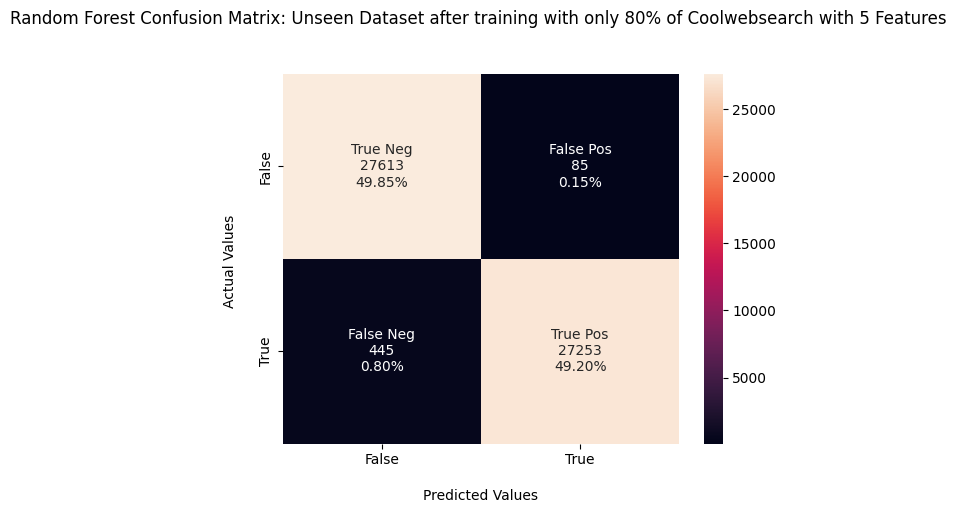

C:\Users\R_A\AppData\Local\Temp\ipykernel_9596\112659327.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


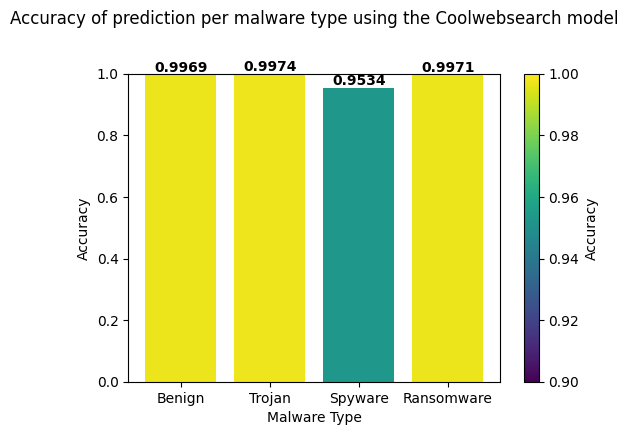

<Figure size 2500x500 with 0 Axes>

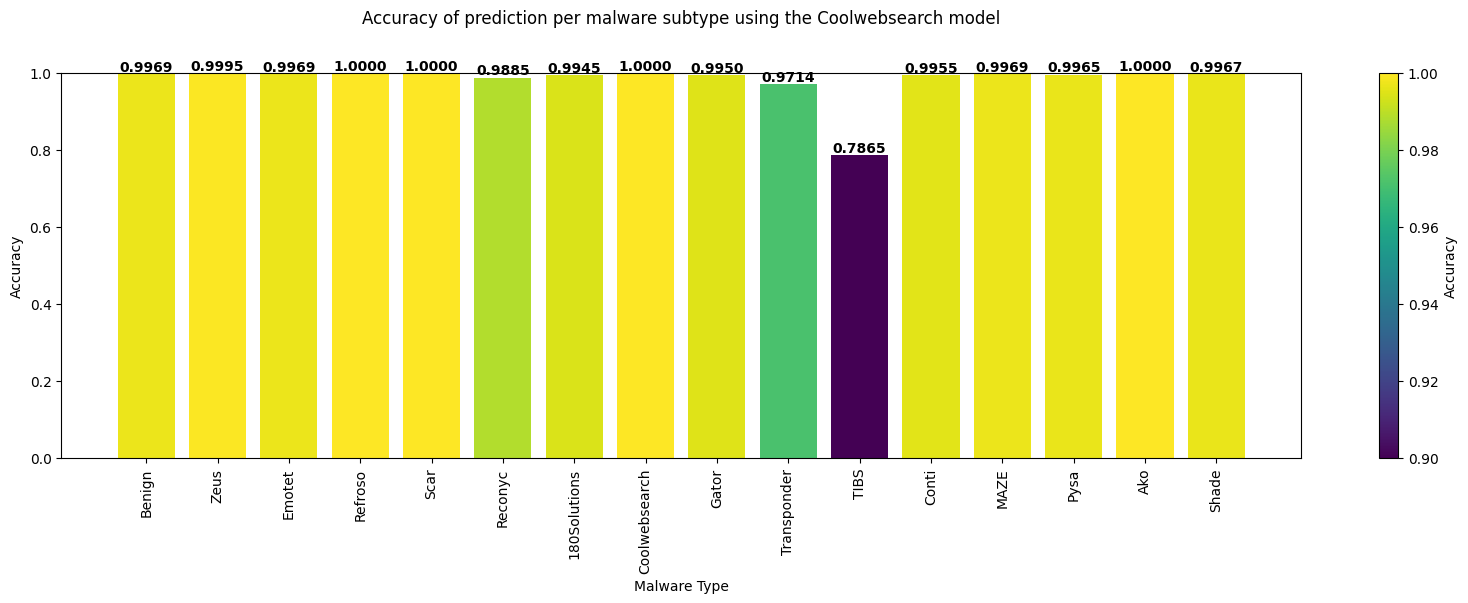

(Malware_type
 Benign        0.996931
 Trojan        0.997365
 Spyware       0.953444
 Ransomware    0.997140
 Name: Accuracy, dtype: float64,
 Malware_subtype
 Benign           0.996931
 Zeus             0.999487
 Emotet           0.996950
 Refroso          1.000000
 Scar             1.000000
 Reconyc          0.988535
 180Solutions     0.994500
 Coolwebsearch    1.000000
 Gator            0.995000
 Transponder      0.971369
 TIBS             0.786525
 Conti            0.995473
 MAZE             0.996936
 Pysa             0.996506
 Ako              1.000000
 Shade            0.996711
 Name: Accuracy, dtype: float64)

In [31]:
#Coolwensearch Subtype
malware_sub='Coolwebsearch'
model= RandomForestClassifier(random_state=0)
selected_features=feature_importance(model, malware_sub)
print(selected_features)
train_predict_novel_malware_2(malware_sub, selected_features)

['svcscan.nservices', 'svcscan.shared_process_services', 'handles.avg_handles_per_proc', 'pslist.avg_handlers', 'handles.nmutant']
Average prediction time: 2.473896253134086e-06 seconds
Standard Deviation of Prediction Time:1.914509233494477e-06 seconds
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     27538
     Malware       1.00      1.00      1.00     27538

    accuracy                           1.00     55076
   macro avg       1.00      1.00      1.00     55076
weighted avg       1.00      1.00      1.00     55076

Accuracy: 0.99771
[[27503    35]
 [   91 27447]]


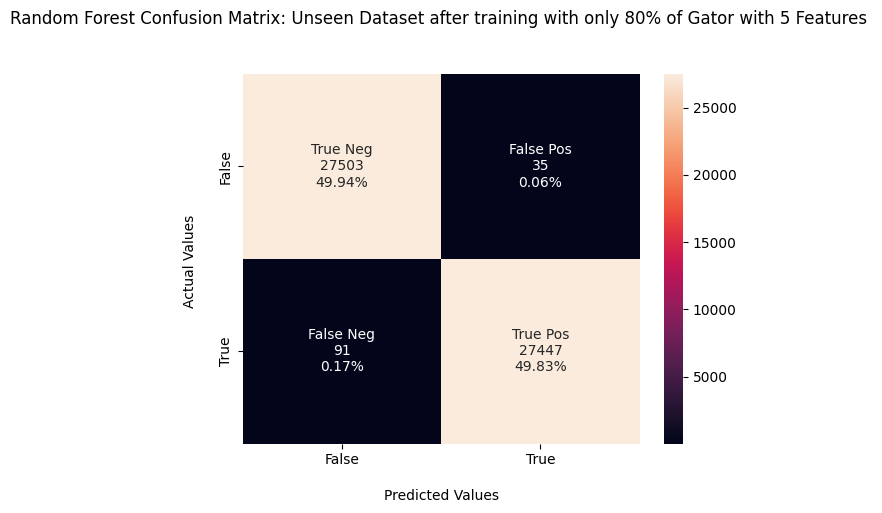

C:\Users\R_A\AppData\Local\Temp\ipykernel_9596\112659327.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


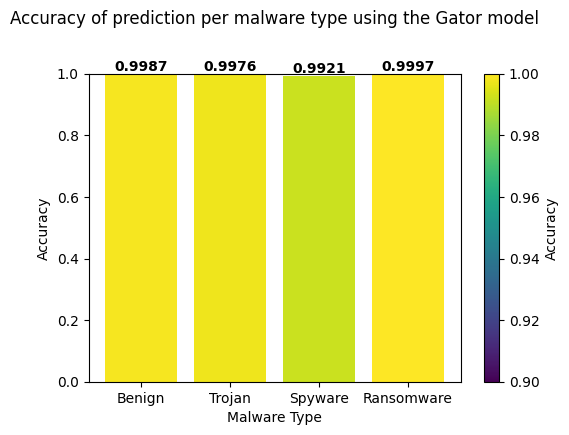

<Figure size 2500x500 with 0 Axes>

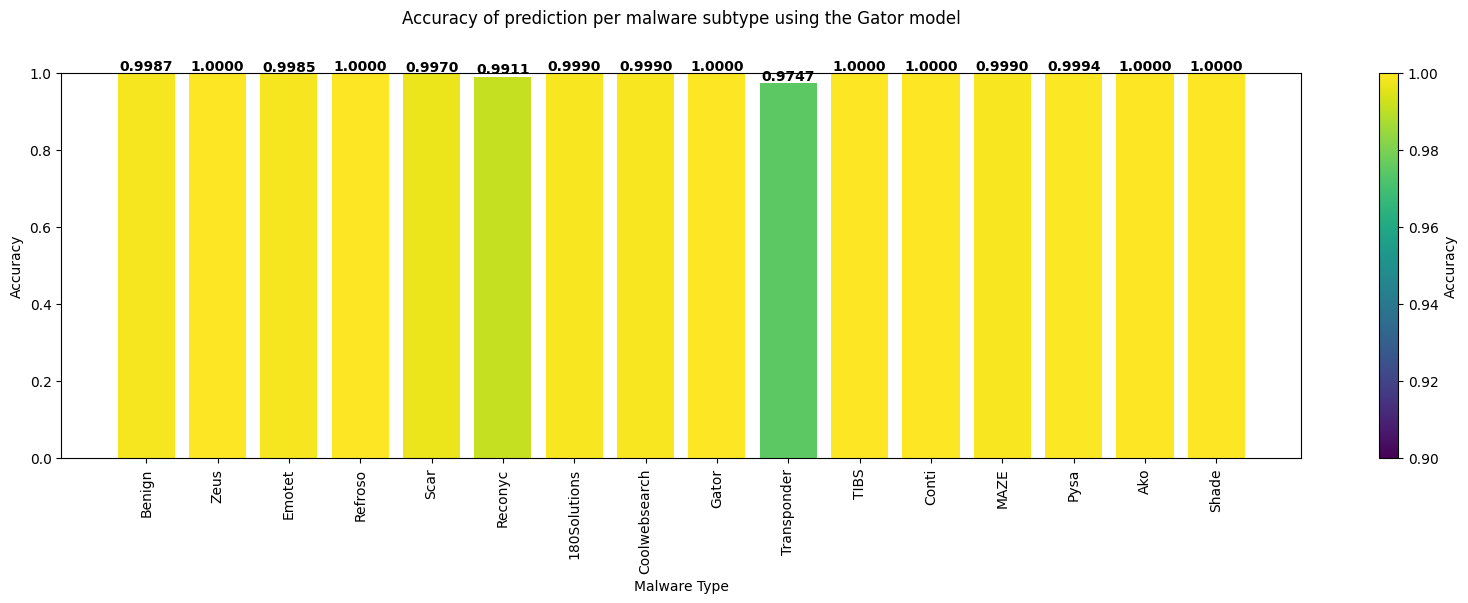

(Malware_type
 Benign        0.998729
 Trojan        0.997576
 Spyware       0.992131
 Ransomware    0.999694
 Name: Accuracy, dtype: float64,
 Malware_subtype
 Benign           0.998729
 Zeus             1.000000
 Emotet           0.998475
 Refroso          1.000000
 Scar             0.997000
 Reconyc          0.991083
 180Solutions     0.999000
 Coolwebsearch    0.999000
 Gator            1.000000
 Transponder      0.974689
 TIBS             1.000000
 Conti            1.000000
 MAZE             0.998979
 Pysa             0.999418
 Ako              1.000000
 Shade            1.000000
 Name: Accuracy, dtype: float64)

In [32]:
#Gator Subtype
malware_sub='Gator'
model= RandomForestClassifier(random_state=0)
selected_features=feature_importance(model, malware_sub)
print(selected_features)
train_predict_novel_malware_2(malware_sub, selected_features)

['svcscan.nservices', 'handles.avg_handles_per_proc', 'svcscan.shared_process_services', 'handles.nevent', 'handles.nmutant']
Average prediction time: 2.312632555677632e-06 seconds
Standard Deviation of Prediction Time:2.9563546676418845e-07 seconds
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     27370
     Malware       1.00      1.00      1.00     27370

    accuracy                           1.00     54740
   macro avg       1.00      1.00      1.00     54740
weighted avg       1.00      1.00      1.00     54740

Accuracy: 0.99837
[[27289    81]
 [    8 27362]]


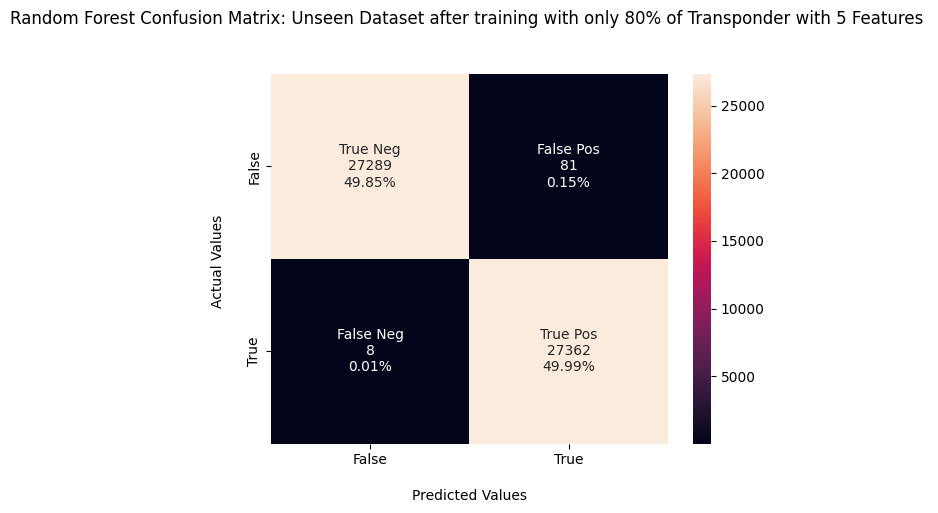

C:\Users\R_A\AppData\Local\Temp\ipykernel_19496\1550231141.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


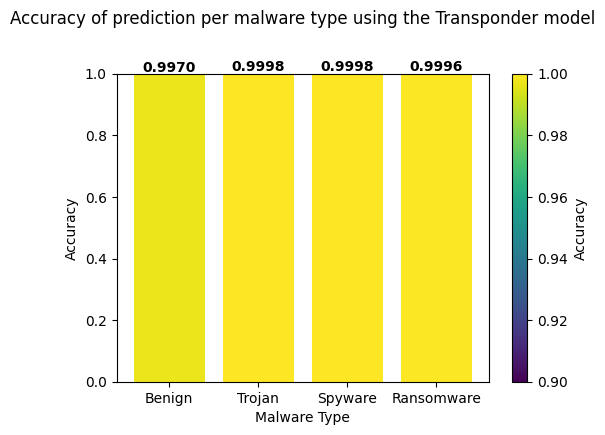

<Figure size 2500x500 with 0 Axes>

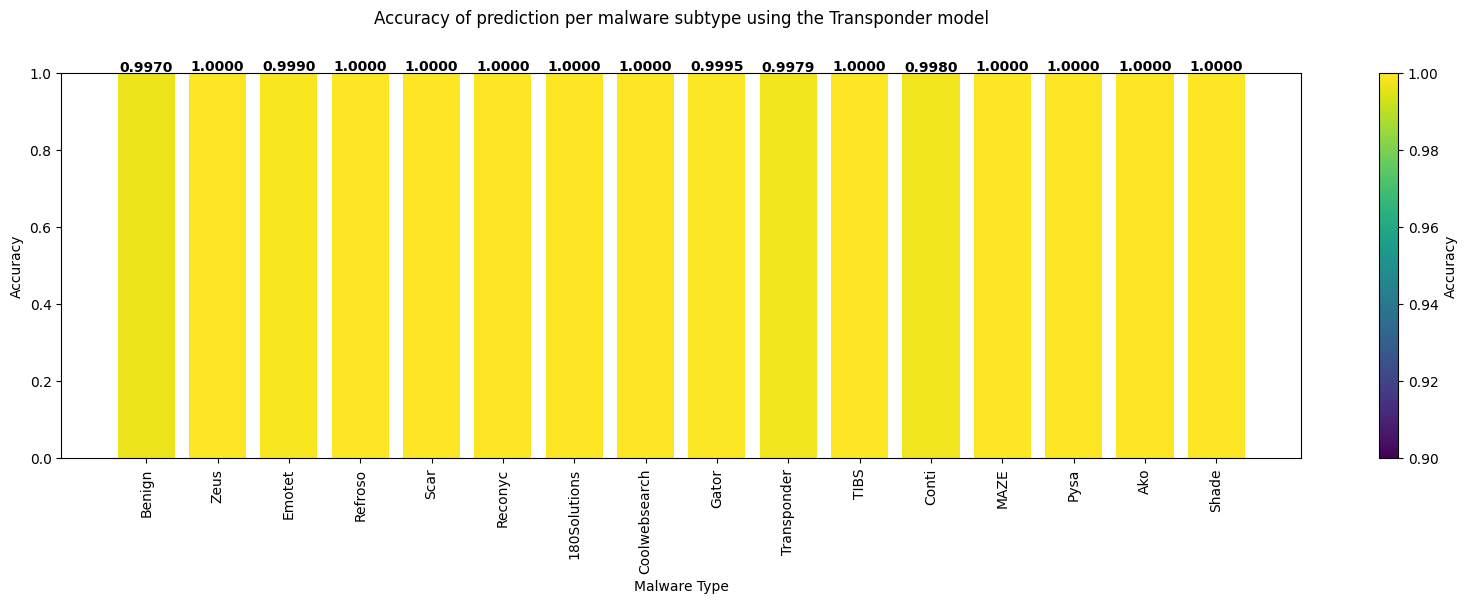

(Malware_type
 Benign        0.997041
 Trojan        0.999789
 Spyware       0.999753
 Ransomware    0.999591
 Name: Accuracy, dtype: float64,
 Malware_subtype
 Benign           0.997041
 Zeus             1.000000
 Emotet           0.998983
 Refroso          1.000000
 Scar             1.000000
 Reconyc          1.000000
 180Solutions     1.000000
 Coolwebsearch    1.000000
 Gator            0.999545
 Transponder      0.997925
 TIBS             1.000000
 Conti            0.997988
 MAZE             1.000000
 Pysa             1.000000
 Ako              1.000000
 Shade            1.000000
 Name: Accuracy, dtype: float64)

In [31]:
#Transponder Subtype
malware_sub='Transponder'
model= RandomForestClassifier(random_state=0)
selected_features=feature_importance(model, malware_sub)
print(selected_features)
train_predict_novel_malware_2(malware_sub, selected_features)

['svcscan.nservices', 'svcscan.shared_process_services', 'handles.nhandles', 'handles.nevent', 'handles.nmutant']
Average prediction time: 2.1630707682554375e-06 seconds
Standard Deviation of Prediction Time:1.0307708328795868e-06 seconds
              precision    recall  f1-score   support

      Benign       0.99      1.00      1.00     28170
     Malware       1.00      0.99      1.00     28170

    accuracy                           1.00     56340
   macro avg       1.00      1.00      1.00     56340
weighted avg       1.00      1.00      1.00     56340

Accuracy: 0.99554
[[28075    95]
 [  156 28014]]


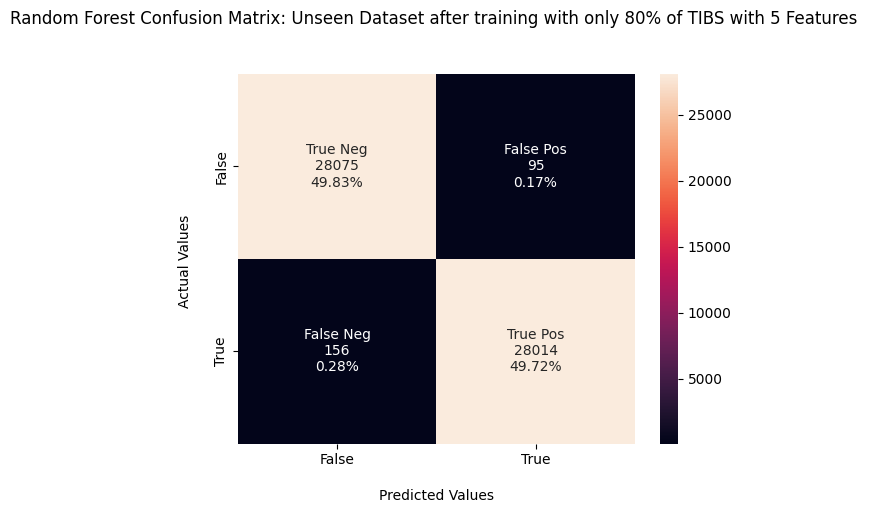

C:\Users\R_A\AppData\Local\Temp\ipykernel_9596\112659327.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


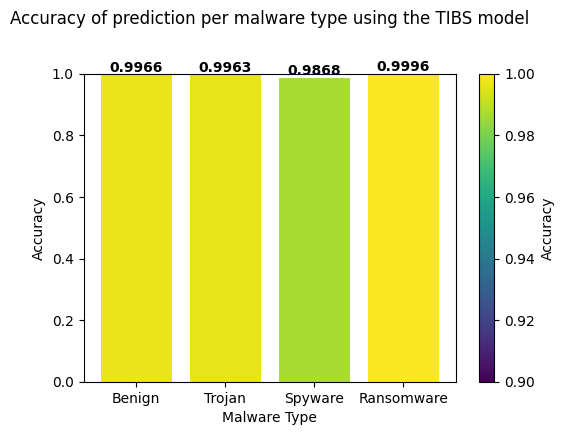

<Figure size 2500x500 with 0 Axes>

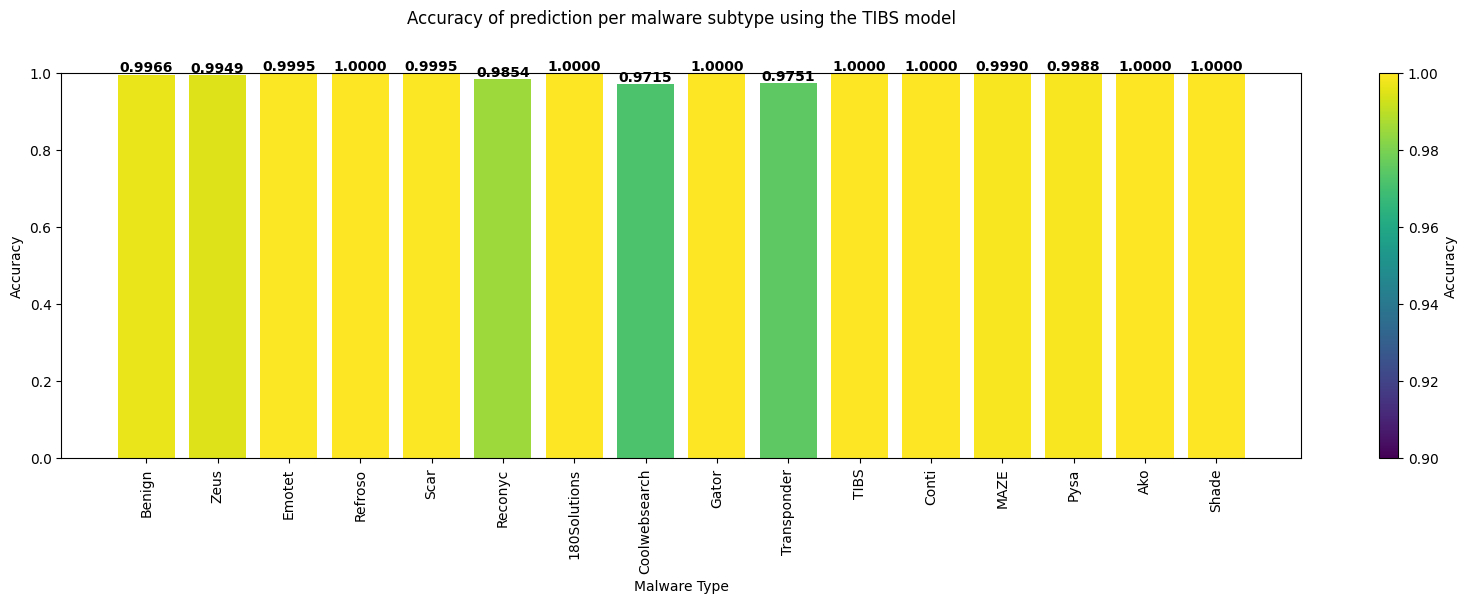

(Malware_type
 Benign        0.996628
 Trojan        0.996311
 Spyware       0.986842
 Ransomware    0.999591
 Name: Accuracy, dtype: float64,
 Malware_subtype
 Benign           0.996628
 Zeus             0.994872
 Emotet           0.999492
 Refroso          1.000000
 Scar             0.999500
 Reconyc          0.985350
 180Solutions     1.000000
 Coolwebsearch    0.971500
 Gator            1.000000
 Transponder      0.975104
 TIBS             1.000000
 Conti            1.000000
 MAZE             0.998979
 Pysa             0.998835
 Ako              1.000000
 Shade            1.000000
 Name: Accuracy, dtype: float64)

In [36]:
#Tibs Subtype
malware_sub='TIBS'
model= RandomForestClassifier(random_state=0)
selected_features=feature_importance(model, malware_sub)
print(selected_features)
train_predict_novel_malware_2(malware_sub, selected_features)

['svcscan.kernel_drivers', 'svcscan.nservices', 'svcscan.shared_process_services', 'handles.nsection', 'handles.nevent']
Average prediction time: 2.504514739233573e-06 seconds
Standard Deviation of Prediction Time:1.5336246608163122e-06 seconds
              precision    recall  f1-score   support

      Benign       0.99      1.00      1.00     27708
     Malware       1.00      0.99      1.00     27708

    accuracy                           1.00     55416
   macro avg       1.00      1.00      1.00     55416
weighted avg       1.00      1.00      1.00     55416

Accuracy: 0.99617
[[27648    60]
 [  152 27556]]


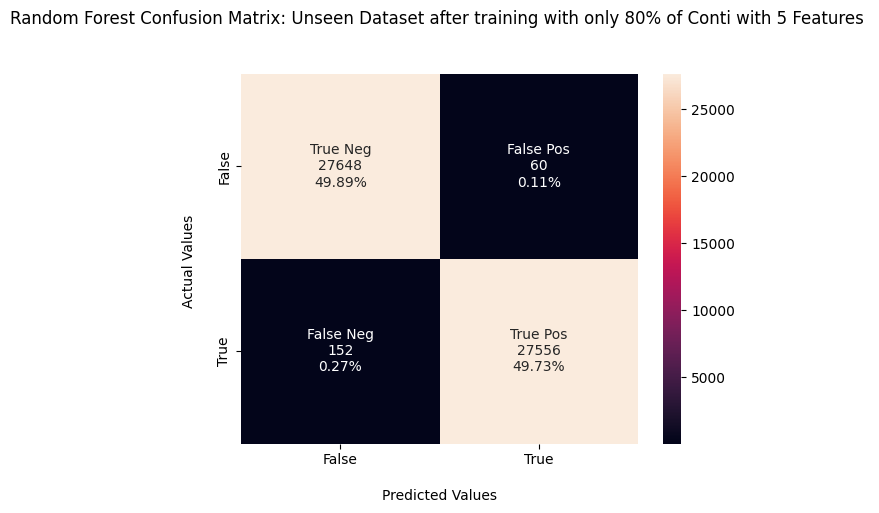

C:\Users\R_A\AppData\Local\Temp\ipykernel_9596\112659327.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


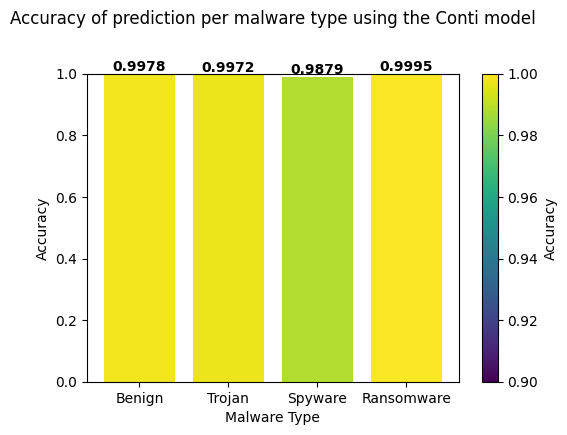

<Figure size 2500x500 with 0 Axes>

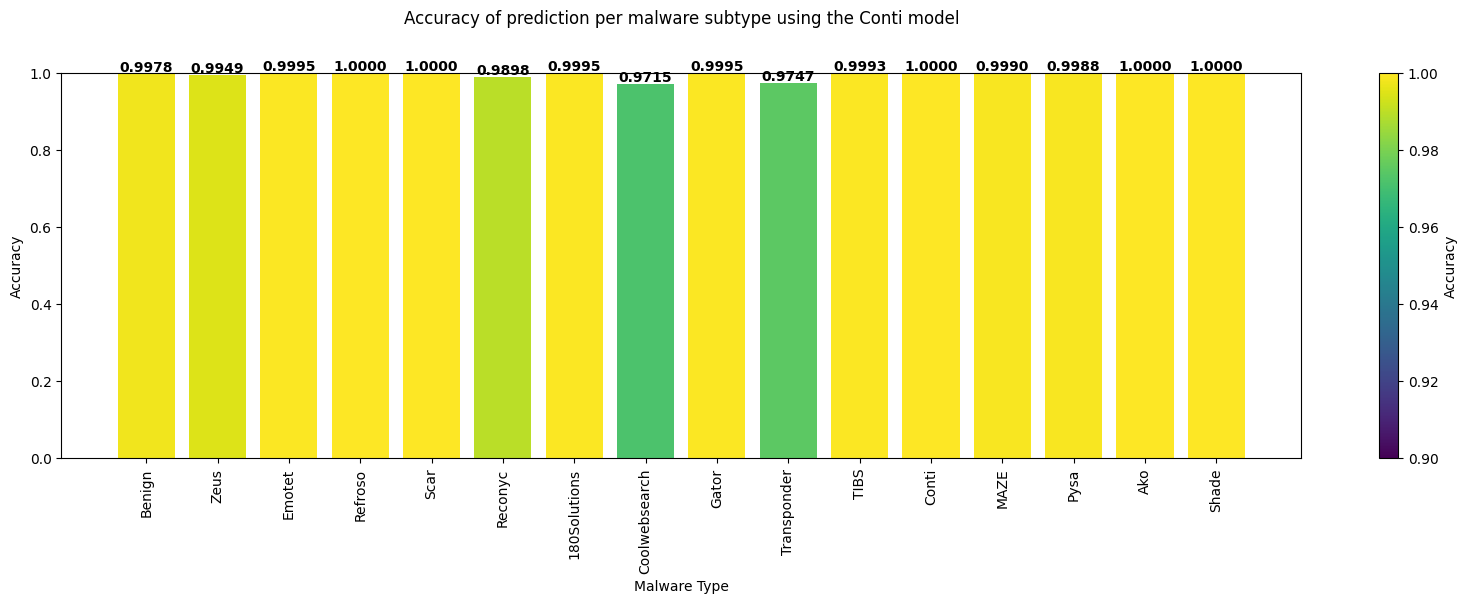

(Malware_type
 Benign        0.997835
 Trojan        0.997154
 Spyware       0.987924
 Ransomware    0.999512
 Name: Accuracy, dtype: float64,
 Malware_subtype
 Benign           0.997835
 Zeus             0.994872
 Emotet           0.999492
 Refroso          1.000000
 Scar             1.000000
 Reconyc          0.989809
 180Solutions     0.999500
 Coolwebsearch    0.971500
 Gator            0.999545
 Transponder      0.974689
 TIBS             0.999291
 Conti            1.000000
 MAZE             0.998979
 Pysa             0.998835
 Ako              1.000000
 Shade            1.000000
 Name: Accuracy, dtype: float64)

In [37]:
#Conti Subtype
malware_sub='Conti'
model= RandomForestClassifier(random_state=0)
selected_features=feature_importance(model, malware_sub)
print(selected_features)
train_predict_novel_malware_2(malware_sub, selected_features)

['handles.nhandles', 'svcscan.shared_process_services', 'svcscan.nservices', 'svcscan.kernel_drivers', 'handles.nmutant']
Average prediction time: 2.4241695504812353e-06 seconds
Standard Deviation of Prediction Time:1.5662373464698471e-06 seconds
              precision    recall  f1-score   support

      Benign       0.99      1.00      1.00     27732
     Malware       1.00      0.99      1.00     27732

    accuracy                           1.00     55464
   macro avg       1.00      1.00      1.00     55464
weighted avg       1.00      1.00      1.00     55464

Accuracy: 0.99531
[[27655    77]
 [  183 27549]]


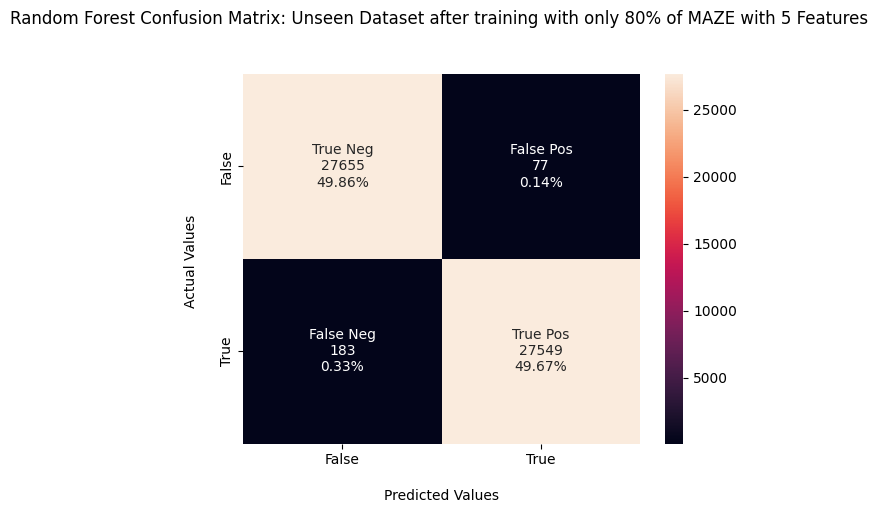

C:\Users\R_A\AppData\Local\Temp\ipykernel_9596\112659327.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


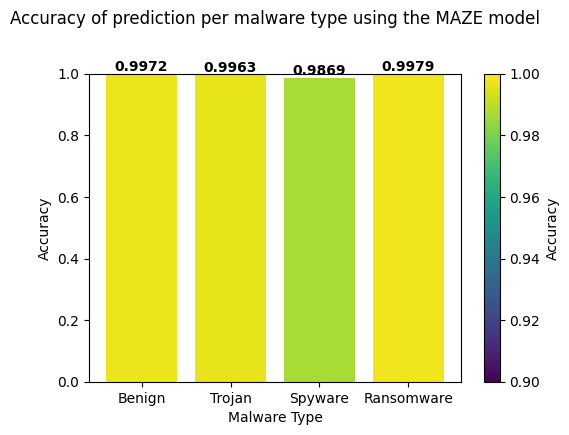

<Figure size 2500x500 with 0 Axes>

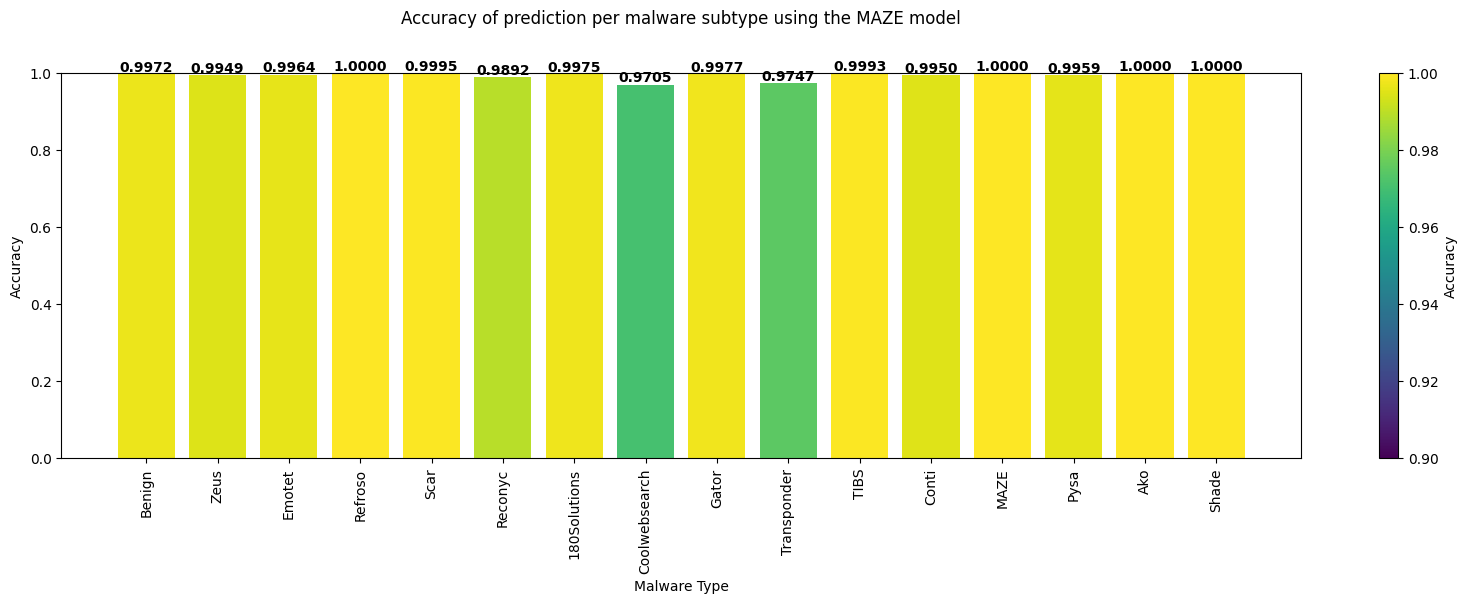

(Malware_type
 Benign        0.997223
 Trojan        0.996311
 Spyware       0.986926
 Ransomware    0.997933
 Name: Accuracy, dtype: float64,
 Malware_subtype
 Benign           0.997223
 Zeus             0.994872
 Emotet           0.996441
 Refroso          1.000000
 Scar             0.999500
 Reconyc          0.989172
 180Solutions     0.997500
 Coolwebsearch    0.970500
 Gator            0.997727
 Transponder      0.974689
 TIBS             0.999291
 Conti            0.994970
 MAZE             1.000000
 Pysa             0.995923
 Ako              1.000000
 Shade            1.000000
 Name: Accuracy, dtype: float64)

In [38]:
#Maze Subtype
malware_sub='MAZE'
model= RandomForestClassifier(random_state=0)
selected_features=feature_importance(model, malware_sub)
print(selected_features)
train_predict_novel_malware_2(malware_sub, selected_features)

['svcscan.nservices', 'svcscan.shared_process_services', 'pslist.avg_handlers', 'svcscan.kernel_drivers', 'handles.nevent']
Average prediction time: 2.547830634599513e-06 seconds
Standard Deviation of Prediction Time:3.0374896419686984e-06 seconds
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     27925
     Malware       1.00      1.00      1.00     27925

    accuracy                           1.00     55850
   macro avg       1.00      1.00      1.00     55850
weighted avg       1.00      1.00      1.00     55850

Accuracy: 0.99739
[[27849    76]
 [   70 27855]]


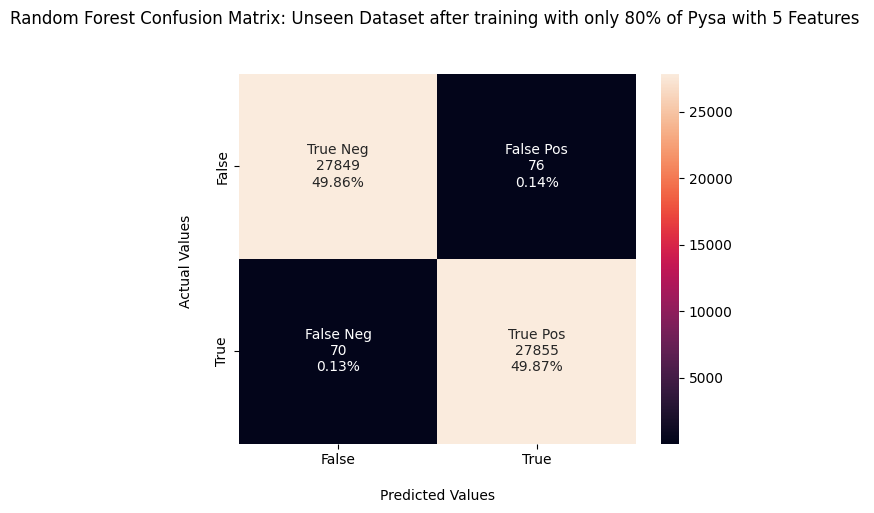

C:\Users\R_A\AppData\Local\Temp\ipykernel_9596\112659327.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


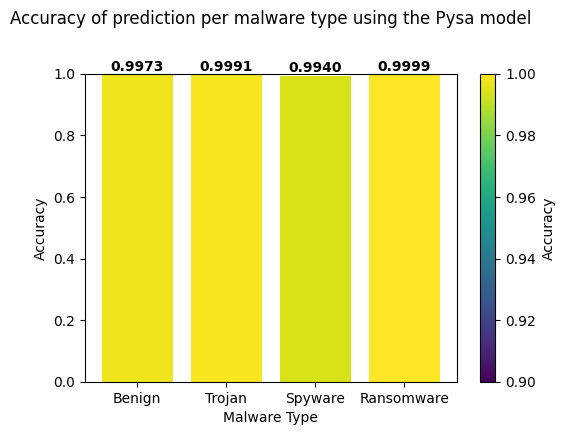

<Figure size 2500x500 with 0 Axes>

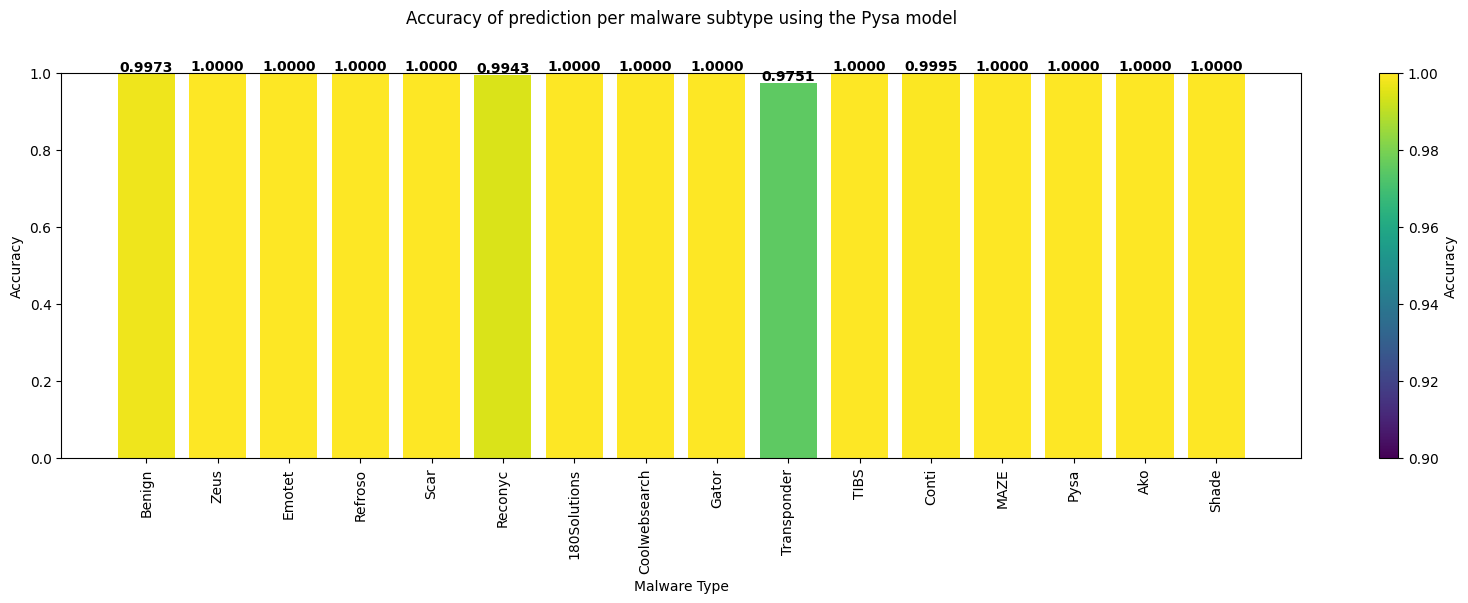

(Malware_type
 Benign        0.997278
 Trojan        0.999051
 Spyware       0.994012
 Ransomware    0.999881
 Name: Accuracy, dtype: float64,
 Malware_subtype
 Benign           0.997278
 Zeus             1.000000
 Emotet           1.000000
 Refroso          1.000000
 Scar             1.000000
 Reconyc          0.994268
 180Solutions     1.000000
 Coolwebsearch    1.000000
 Gator            1.000000
 Transponder      0.975104
 TIBS             1.000000
 Conti            0.999497
 MAZE             1.000000
 Pysa             1.000000
 Ako              1.000000
 Shade            1.000000
 Name: Accuracy, dtype: float64)

In [39]:
#pysa Subtype
malware_sub='Pysa'
model= RandomForestClassifier(random_state=0)
selected_features=feature_importance(model, malware_sub)
print(selected_features)
train_predict_novel_malware_2(malware_sub, selected_features)

['svcscan.nservices', 'pslist.avg_handlers', 'svcscan.shared_process_services', 'dlllist.avg_dlls_per_proc', 'svcscan.kernel_drivers']
Average prediction time: 3.724453961240642e-06 seconds
Standard Deviation of Prediction Time:5.798801170249131e-05 seconds
              precision    recall  f1-score   support

      Benign       0.97      1.00      0.98     27698
     Malware       1.00      0.97      0.98     27698

    accuracy                           0.98     55396
   macro avg       0.98      0.98      0.98     55396
weighted avg       0.98      0.98      0.98     55396

Accuracy: 0.98437
[[27682    16]
 [  850 26848]]


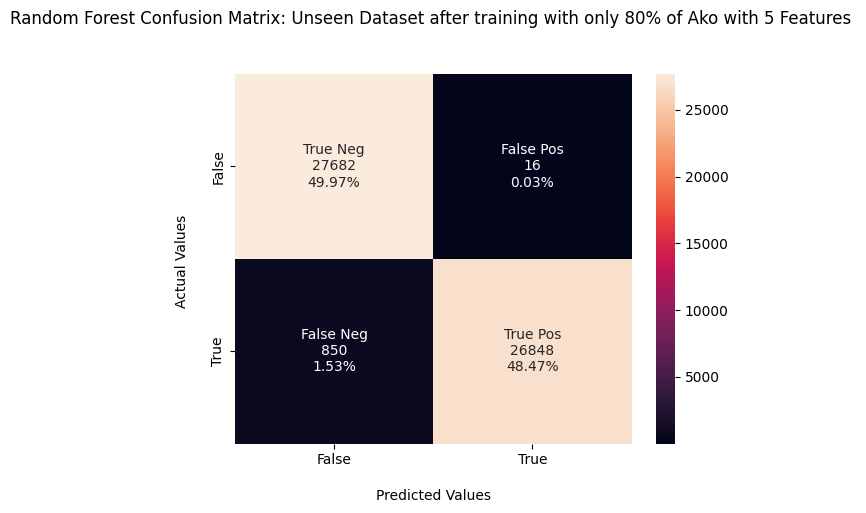

C:\Users\R_A\AppData\Local\Temp\ipykernel_9596\112659327.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


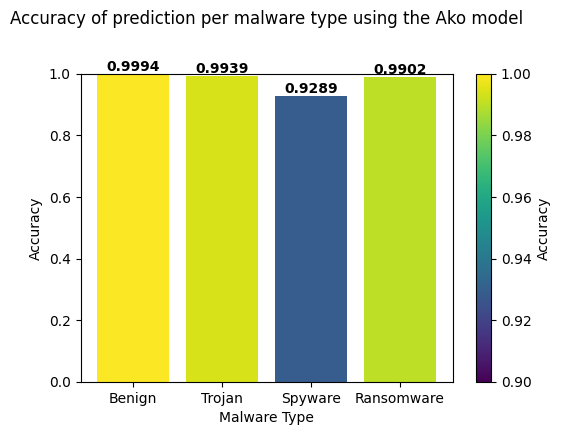

<Figure size 2500x500 with 0 Axes>

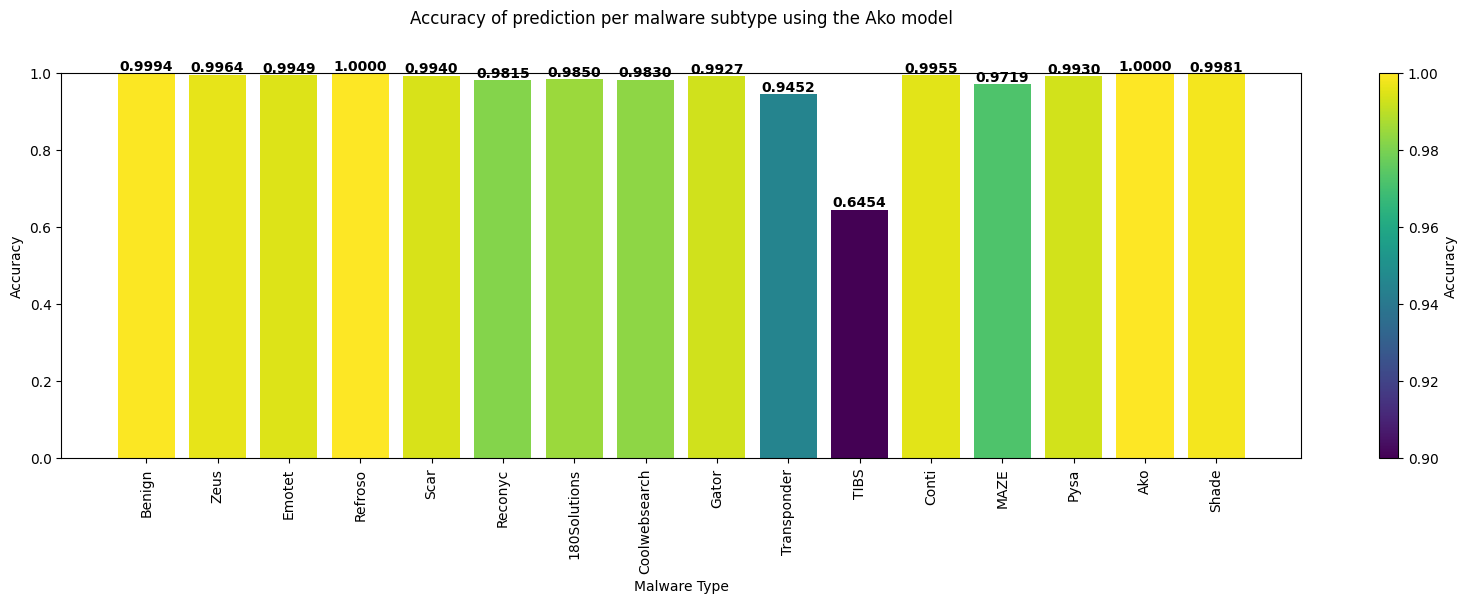

(Malware_type
 Benign        0.999422
 Trojan        0.993886
 Spyware       0.928942
 Ransomware    0.990233
 Name: Accuracy, dtype: float64,
 Malware_subtype
 Benign           0.999422
 Zeus             0.996410
 Emotet           0.994916
 Refroso          1.000000
 Scar             0.994000
 Reconyc          0.981529
 180Solutions     0.985000
 Coolwebsearch    0.983000
 Gator            0.992727
 Transponder      0.945228
 TIBS             0.645390
 Conti            0.995473
 MAZE             0.971910
 Pysa             0.993011
 Ako              1.000000
 Shade            0.998120
 Name: Accuracy, dtype: float64)

In [40]:
#Ako Subtype
malware_sub='Ako'
model= RandomForestClassifier(random_state=0)
selected_features=feature_importance(model, malware_sub)
print(selected_features)
train_predict_novel_malware_2(malware_sub, selected_features)

['svcscan.nservices', 'svcscan.shared_process_services', 'svcscan.kernel_drivers', 'handles.nevent', 'dlllist.avg_dlls_per_proc']
Average prediction time: 1.9945886916467326e-06 seconds
Standard Deviation of Prediction Time:7.316885986916361e-07 seconds
              precision    recall  f1-score   support

      Benign       0.98      1.00      0.99     27596
     Malware       1.00      0.98      0.99     27596

    accuracy                           0.99     55192
   macro avg       0.99      0.99      0.99     55192
weighted avg       0.99      0.99      0.99     55192

Accuracy: 0.99047
[[27547    49]
 [  477 27119]]


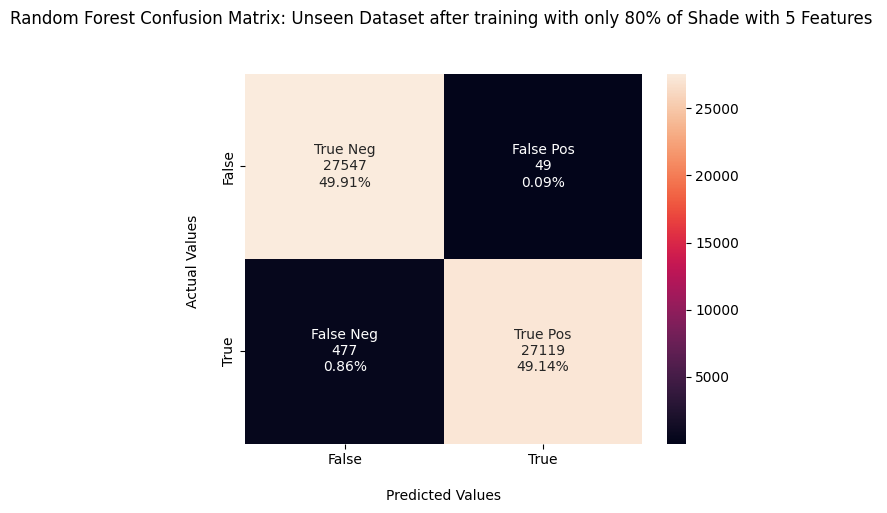

C:\Users\R_A\AppData\Local\Temp\ipykernel_9596\112659327.py:140: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('viridis')


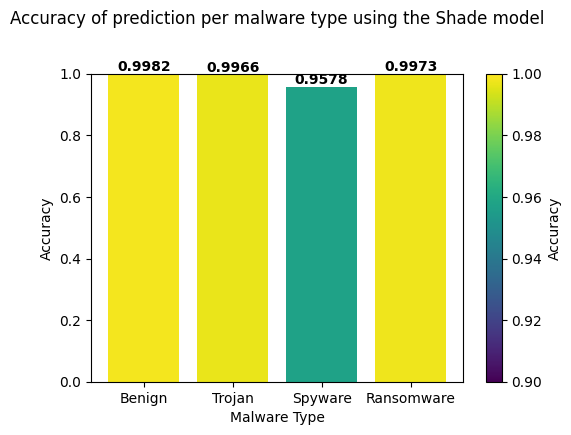

<Figure size 2500x500 with 0 Axes>

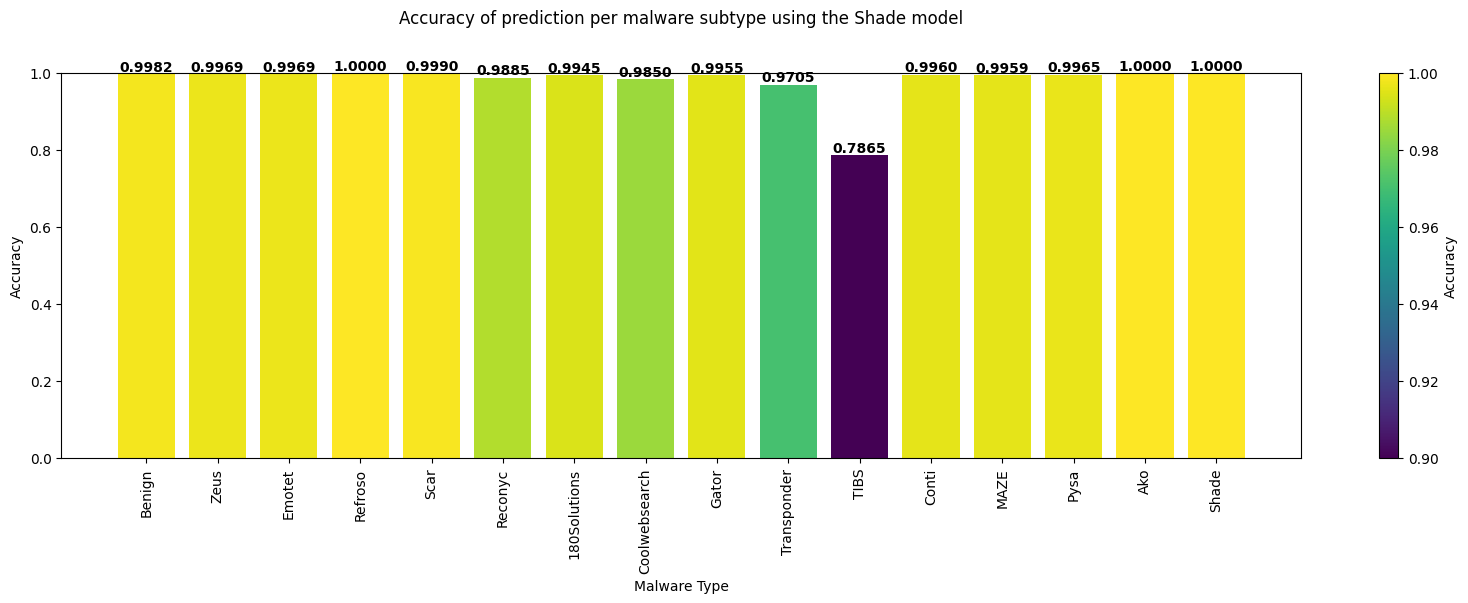

(Malware_type
 Benign        0.998224
 Trojan        0.996627
 Spyware       0.957784
 Ransomware    0.997280
 Name: Accuracy, dtype: float64,
 Malware_subtype
 Benign           0.998224
 Zeus             0.996923
 Emotet           0.996950
 Refroso          1.000000
 Scar             0.999000
 Reconyc          0.988535
 180Solutions     0.994500
 Coolwebsearch    0.985000
 Gator            0.995455
 Transponder      0.970539
 TIBS             0.786525
 Conti            0.995976
 MAZE             0.995914
 Pysa             0.996506
 Ako              1.000000
 Shade            1.000000
 Name: Accuracy, dtype: float64)

In [41]:
#Shade Subtype
malware_sub='Shade'
model= RandomForestClassifier(random_state=0)
selected_features=feature_importance(model, malware_sub)
print(selected_features)
train_predict_novel_malware_2(malware_sub, selected_features)

Comparing the results of model :

In [22]:
### Create a DataFrame to compare the accuracy of each malware subtype focused model
Malware_type = [
    'Trojan Horse', 'Trojan Horse', 'Trojan Horse', 'Trojan Horse', 'Trojan Horse',
    'Spyware', 'Spyware', 'Spyware', 'Spyware', 'Spyware',
    'Ransomware', 'Ransomware', 'Ransomware', 'Ransomware', 'Ransomware'
]

Malware_subtype = [
    'Emotet', 'Reconyc', 'Refroso', 'Scar', 'Zeus',
    '180Sulotions', 'CoolWebSearch', 'Gator', 'TIBS', 'Transponder',
    'Ako', 'Conti', 'MAZE', 'Pysa', 'Shade'
]

Accuracy = [
    0.9901, 0.9967, 0.9810, 0.9810, 0.9800,
    0.9972, 0.9904, 0.9977, 0.9955, 0.9984,
    0.9844, 0.9962, 0.9953, 0.9974, 0.9905
]

Subtype_compar_df = pd.DataFrame({
    'Malware_type': Malware_type,
    'Malware_subtype': Malware_subtype,
    'Accuracy': Accuracy
})

# Sort the DataFrame by Malware_type and Accuracy
Subtype_compar_df = Subtype_compar_df.sort_values(by=['Malware_type', 'Accuracy'], ascending=[False, False])
#Subtype_compar_df = Subtype_compar_df.sort_values(by=['Accuracy'], ascending=[False])
Subtype_compar_df.reset_index(drop=True,inplace=True)
Subtype_compar_df.index += 1
# Display the DataFrame
Subtype_compar_df

Malware_type Malware_subtype  Accuracy
1   Trojan Horse         Reconyc    0.9967
2   Trojan Horse          Emotet    0.9901
3   Trojan Horse         Refroso    0.9810
4   Trojan Horse            Scar    0.9810
5   Trojan Horse            Zeus    0.9800
6        Spyware     Transponder    0.9984
7        Spyware           Gator    0.9977
8        Spyware    180Sulotions    0.9972
9        Spyware            TIBS    0.9955
10       Spyware   CoolWebSearch    0.9904
11    Ransomware            Pysa    0.9974
12    Ransomware           Conti    0.9962
13    Ransomware            MAZE    0.9953
14    Ransomware           Shade    0.9905
15    Ransomware             Ako    0.9844

Plot the accuracy in a bar chart for better visuallization :

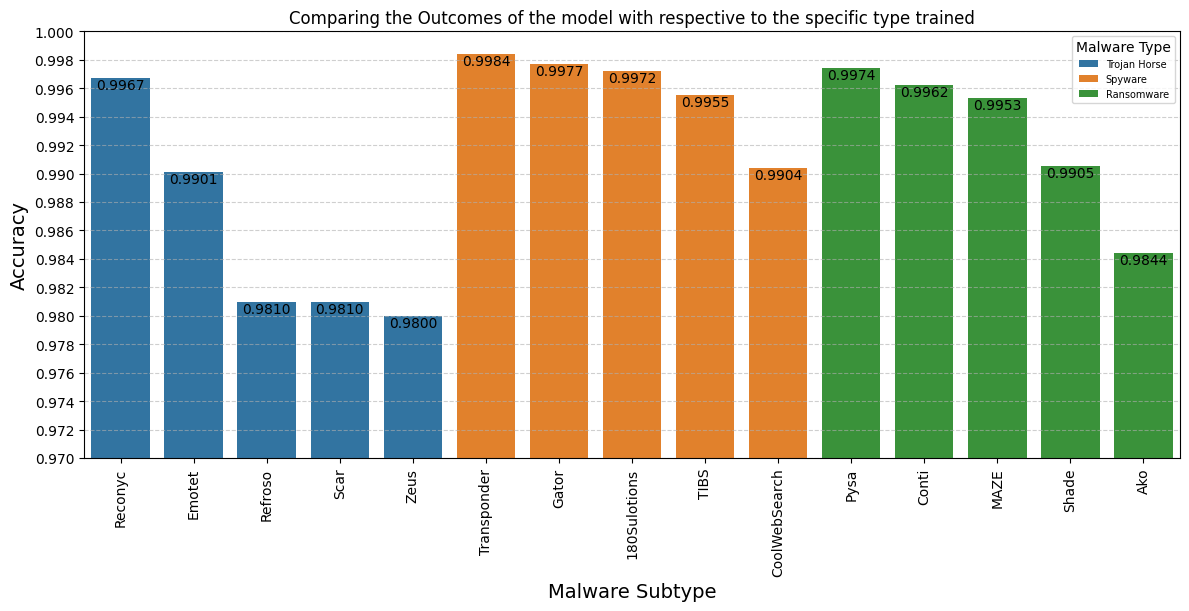

In [23]:
### Plot the accuracy of each malware subtype focused model
fig, ax = plt.subplots(figsize=(12, 6))

# Create the bar plot with adjusted bar width
sns.barplot(
    ax=ax,
    data=Subtype_compar_df,
    x='Malware_subtype',
    y='Accuracy',
    hue='Malware_type',
    palette='tab10',
    dodge=False # Avoid splitting bars for multiple hues
)
for bar in ax.patches:
    height = bar.get_height()  # Get bar height (accuracy value)
    if  height > 0 :
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
            height ,  # Y position (slightly below the top)
            f'{height:.4f}',  # Format value to 3 decimal places
            ha='center', 
            va='top', 
            fontsize=10, 
            color='black'
        )

# Center the ticks under each bar and adjust bar thickness
ax.set_ylim(0.97, 1)
ax.set_yticks([0.97 + i * 0.002 for i in range(16)])
# Add axis labels and legend
ax.set_xlabel('Malware Subtype', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.legend(title='Malware Type', fontsize=7, loc='upper right')
ax.set_title("Comparing the Outcomes of the model with respective to the specific type trained")

# Rotate x-axis tick labels for better readability
ax.tick_params(axis='x', rotation=45)

# Add grid
ax.grid(axis='y', linestyle='--', alpha=0.6)
# Show the plot
plt.tight_layout()
plt.xticks(rotation=90)
plt.show()

# Export the plot to a jpg file with high resolution
fig.savefig('Malware_subtype_accuracy_comparison.jpg', dpi=400)

Module_3-Model Explainability

In [18]:
import shap
from shap.plots import beeswarm
from shap.plots import bar
from wordcloud import WordCloud
shap.initjs()

In [19]:
rfc = RandomForestClassifier(random_state=0)
selected_features1=feature_importance(rfc, 'Transponder')
selected_features1

['svcscan.nservices',
 'handles.avg_handles_per_proc',
 'svcscan.shared_process_services',
 'handles.nevent',
 'handles.nmutant']

In [20]:
# dictionary that maps the malware subtype to its corresponding label
label_dict = {
    0: 'Benign',
    1.1: 'Zeus',
    1.2: 'Emotet',
    1.3: 'Refroso',
    1.4: 'Scar',
    1.5: 'Reconyc',
    2.1: '180Solutions',
    2.2: 'Coolwebsearch',
    2.3: 'Gator',
    2.4: 'Transponder',
    2.5: 'TIBS',
    3.1: 'Conti',
    3.2: 'MAZE',
    3.3: 'Pysa',
    3.4: 'Ako',
    3.5: 'Shade'
    }
# Reverse the dictionary
label_dict = {v: k for k, v in label_dict.items()}


malware_subtype_label = label_dict['Transponder']
# From df, create a dataset "df_train" that contains only the chosen malware subtype
df_selected_subtype = df[df['Malware_subtype'] == malware_subtype_label]

# Calculate the number of rows to copy (80% of the selected subtype)
percentage_to_copy = 0.8
num_rows_to_copy = int(len(df_selected_subtype) * percentage_to_copy)
# Shuffle the data to ensure randomness
df_selected_subtype = df_selected_subtype.sample(frac=1, random_state=1)
# Copy the first 80% of rows with the chosen malware subtype into df_train
df_train = df_selected_subtype.head(num_rows_to_copy)

# Include the remaining 20% of rows with the chosen malware subtype in df_to_predict
df_to_predict = df_selected_subtype.tail(len(df_selected_subtype) - num_rows_to_copy)

# Create a dataset "df_remaining" that contains all other data
df_remaining = df[df['Malware_subtype'] != malware_subtype_label]

# Combine df_to_predict with df_remaining to form the final df_to_predict dataframe
df_to_predict = pd.concat([df_to_predict, df_remaining])

benign_index = df_to_predict[df_to_predict['Malware_type'] == 0].sample(n=len(df_train), random_state=1).index

# Add the sampled benign cases to df_train
df_train = pd.concat([df_train, df_to_predict.loc[benign_index]])

# Remove the sampled benign cases from df_to_predict
df_to_predict = df_to_predict.drop(benign_index)

X_train = df_train[selected_features1]
Y_train = df_train["Class"]

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the features to the [0, 1] range
X_train_scaled = scaler.fit_transform(X_train)

# Convert into a DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=scaler.feature_names_in_)

# Preparing the test dataset
X_new = df_to_predict[selected_features1]
Y_new = df_to_predict["Class"]

X_new_scaled = scaler.transform(X_new)
# Convert X_new to a dataframe
X_new_scaled = pd.DataFrame(X_new_scaled, columns = scaler.feature_names_in_)
# Set the index of X_new_scaled to match the index of X_new
X_new_scaled.index = X_new.index
### RandomForestClassifier
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train_scaled, Y_train)
# Explain using SHAP
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_new_scaled)
#shap_values = explainer(X_new_scaled,check_additivity=False)
#beeswarm(shap_values[:,:,1])
#shap.summary_plot(shap_values,X_new_scaled)

'''# Get feature names
feature_names = X_new_scaled.columns

# Calculate mean absolute SHAP values for each class
class_names = ["Class 0", "Class 1"]
mean_shap_values = [np.abs(shap_values[i]).mean(0) for i in range(len(shap_values))]

# Sort features by overall importance
feature_importance = np.sum(mean_shap_values, axis=0)
sorted_idx = np.argsort(feature_importance)
sorted_features = [feature_names[i] for i in sorted_idx[-5:]]  # Get top 5 features

# Plot
# Adjust the figure size to accommodate all 5 features
plt.figure(figsize=(5,4))

# Get the top 5 features based on importance
feature_importance = np.sum([np.abs(shap_values[i]).mean(0) for i in range(len(shap_values))], axis=0)
top_indices = np.argsort(feature_importance)[-5:]  # Get indices of top 5 features
top_features = [feature_names[i] for i in top_indices]

# Create y-positions for all 5 features
y_pos = np.arange(len(top_features))
width = 0.1

# Plot bars for each class
for i, class_name in enumerate(['Class 0', 'Class 1']):
    plt.barh(y_pos + (width * (i )), 
             [np.abs(shap_values[i][:, j]).mean() for j in top_indices], 
             width, 
             label=class_name,
             color='red' if i == 0 else 'dodgerblue')

# Customize plot
plt.yticks(y_pos, top_features)
plt.xlabel('mean(|SHAP value|) (average impact on model output magnitude)')
plt.title('SHAP Explanation for with 5 Features')
plt.legend()
plt.tight_layout()
plt.show()
'''

'# Get feature names\nfeature_names = X_new_scaled.columns\n\n# Calculate mean absolute SHAP values for each class\nclass_names = ["Class 0", "Class 1"]\nmean_shap_values = [np.abs(shap_values[i]).mean(0) for i in range(len(shap_values))]\n\n# Sort features by overall importance\nfeature_importance = np.sum(mean_shap_values, axis=0)\nsorted_idx = np.argsort(feature_importance)\nsorted_features = [feature_names[i] for i in sorted_idx[-5:]]  # Get top 5 features\n\n# Plot\n# Adjust the figure size to accommodate all 5 features\nplt.figure(figsize=(5,4))\n\n# Get the top 5 features based on importance\nfeature_importance = np.sum([np.abs(shap_values[i]).mean(0) for i in range(len(shap_values))], axis=0)\ntop_indices = np.argsort(feature_importance)[-5:]  # Get indices of top 5 features\ntop_features = [feature_names[i] for i in top_indices]\n\n# Create y-positions for all 5 features\ny_pos = np.arange(len(top_features))\nwidth = 0.1\n\n# Plot bars for each class\nfor i, class_name in enum

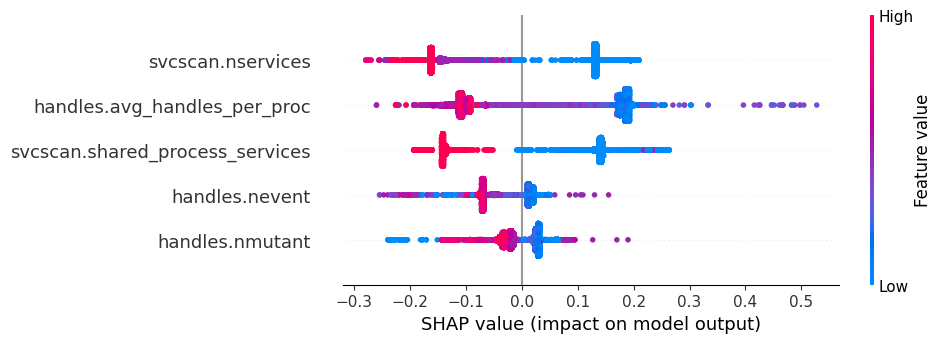

In [21]:
shap_values = explainer(X_new_scaled,check_additivity=False)
beeswarm(shap_values[:,:,1])

In [22]:
selected_features11=selected_features1.copy()
selected_features11.insert(0, 'Category')
selected_features11

['Category',
 'svcscan.nservices',
 'handles.avg_handles_per_proc',
 'svcscan.shared_process_services',
 'handles.nevent',
 'handles.nmutant']

In [23]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_new_scaled)

In [24]:
index = 100

In [25]:
df_to_predict.loc[[index], selected_features11]

Category  svcscan.nservices  handles.avg_handles_per_proc  \
100   Benign                395                     306.18503   

     svcscan.shared_process_services  handles.nevent  handles.nmutant  
100                              118            4594              403

In [26]:
choosen_instance=X_new_scaled.loc[[index]]
choosen_instance

svcscan.nservices  handles.avg_handles_per_proc  \
100                1.0                      0.931878   

     svcscan.shared_process_services  handles.nevent  handles.nmutant  
100                              1.0        0.647626         0.623632

In [27]:
prediction = rfc.predict(choosen_instance)[0]

# Assuming 0 = Benign, anything else = Malware
label = "Benign" if prediction == 0 else "Malware"

print(f"Predicted Class for the chosen instance: {prediction} ({label})")

Predicted Class for the chosen instance: 0 (Benign)


In [28]:
index = 10050

In [29]:
df_to_predict.loc[[index], selected_features11]

Category  svcscan.nservices  \
10050  Trojan-Refroso-1e83d38b1f0909525d3ed6848f69bb7...                389   

       handles.avg_handles_per_proc  svcscan.shared_process_services  \
10050                       208.525                              116   

       handles.nevent  handles.nmutant  
10050            2898              261

In [30]:
choosen_instance=X_new_scaled.loc[[index]]
choosen_instance

svcscan.nservices  handles.avg_handles_per_proc  \
10050            0.97931                      0.344859   

       svcscan.shared_process_services  handles.nevent  handles.nmutant  
10050                         0.977011        0.344877          0.31291

In [31]:
prediction = rfc.predict(choosen_instance)[0]

# Assuming 0 = Benign, anything else = Malware
label = "Benign" if prediction == 0 else "Malware"

print(f"Predicted Class for the chosen instance: {prediction} ({label})")

Predicted Class for the chosen instance: 1 (Malware)


In [81]:
print(rfc.predict(X_new_scaled.iloc[:]))

[1 1 1 ... 0 0 1]


X_train shape: (46876, 52)
X_test shape: (11720, 52)
Original SHAP values shape: (11720, 52, 2)


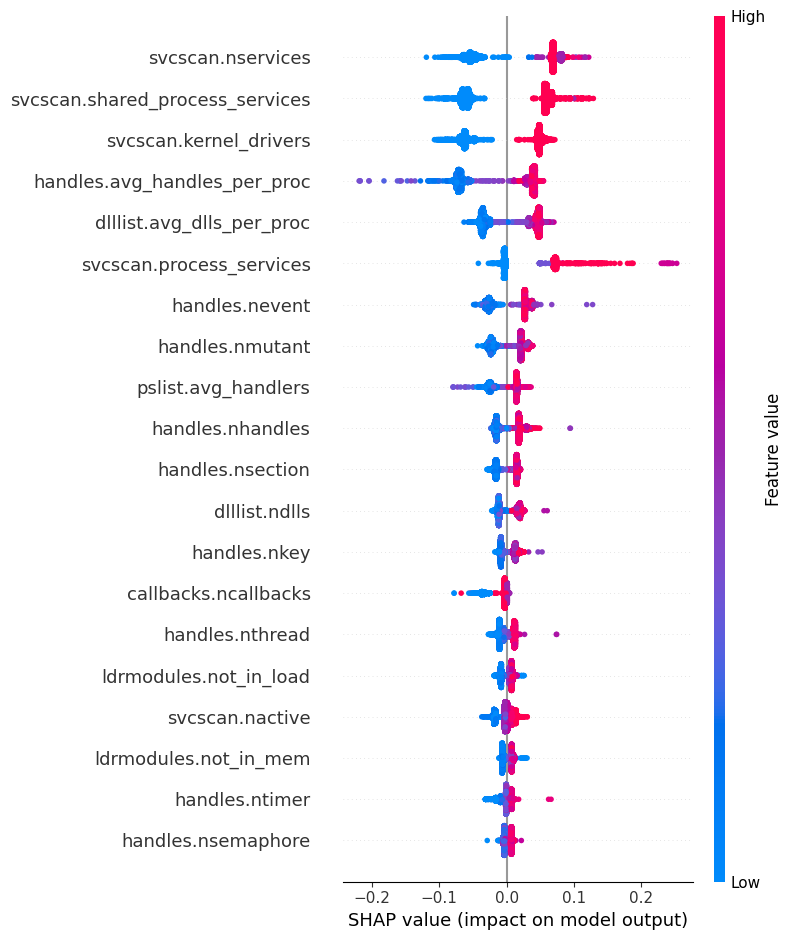

In [35]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Define and train Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(x_train, y_train)

y_pred=rfc.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)*100

print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
explainer = shap.TreeExplainer(rfc) #to reduce computation time
shap_values = explainer.shap_values(x_test[:], check_additivity=False) 
    
print("Original SHAP values shape:", shap_values.shape)
    
shap.initjs()
shap.summary_plot(
    shap_values=shap_values[:,:, 0],  # SHAP values for the specified class "0==class benign"
    features=x_test[:],  # Reshaped feature matrix
    feature_names=x_test.columns  # Feature names
)

In [36]:
index_benign=-1
index_malware=-1
for index,sample in enumerate(x_test):
    if y_test.iloc[index]==0 and index_benign==-1:
        index_benign=index
    if y_test.iloc[index]==1 and index_malware==-1:
        index_malware=index
        break  
print(index_benign)
print(index_malware)

0
1


In [37]:
index_benign=100
print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
explainer = shap.TreeExplainer(rfc) #to reduce computation time
shap_values = explainer.shap_values(x_test[:], check_additivity=False) 
    
print("Original SHAP values shape:", shap_values.shape)
    
shap.initjs()
force_plot=shap.plots.force(
    explainer.expected_value[0],
    shap_values=shap_values[index_benign][:,0],  # SHAP values for the specified class
    feature_names=x_test.columns,  # Feature names
)
shap.save_html("force_plot_benign1.html", force_plot)
from IPython.display import IFrame
IFrame('force_plot_benign1.html', width=1000, height=200)


X_train shape: (46876, 52)
X_test shape: (11720, 52)
Original SHAP values shape: (11720, 52, 2)


In [38]:
index_malware=200
print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
explainer = shap.TreeExplainer(rfc) #to reduce computation time
shap_values = explainer.shap_values(x_test[:], check_additivity=False) 
    
print("Original SHAP values shape:", shap_values.shape)
    
shap.initjs()
force_plot=shap.plots.force(
    explainer.expected_value[0],
    shap_values=shap_values[index_malware][:,1],  # SHAP values for the specified class
    feature_names=x_test.columns,  # Feature names
)
shap.save_html("force_plot_malware2.html", force_plot)
from IPython.display import IFrame
IFrame('force_plot_malware2.html', width=1000, height=200)

X_train shape: (46876, 52)
X_test shape: (11720, 52)
Original SHAP values shape: (11720, 52, 2)


In [39]:
IFrame('force_plot_benign1.html', width=1000, height=200)

In [40]:
IFrame('force_plot_malware2.html', width=1000, height=200)

In [73]:
def predict_instance(rfc, scaler, selected_features, mode='manual', choosen_index=None, df_to_predict=None):
    if mode == 'manual':
        print("\nManual Mode: Please input values for the top 5 features (between 0 and 1)")
        user_input = []
        for feature in selected_features:
            while True:
                try:
                    val = float(input(f"Enter value for '{feature}' (0 to 1): "))
                    if 0.0 <= val <= 1.0:
                        user_input.append(val)
                        break
                    else:
                        print("Please enter a value between 0 and 1.")
                except ValueError:
                    print("Invalid input. Please enter a numeric value.")
        
        choosen_instance = pd.DataFrame([user_input], columns=selected_features)

    elif mode == 'dataset':
        if choosen_index is None or df_to_predict is None:
            raise ValueError("For 'dataset' mode, 'choosen_index' and 'df_to_predict' must be provided.")

        if choosen_index not in df_to_predict.index:
            print(f"Index {choosen_index} not found in dataset. Please try again.")
            return

        X_new = df_to_predict[selected_features]
        X_new_scaled = scaler.transform(X_new)
        X_new_scaled = pd.DataFrame(X_new_scaled, columns=selected_features, index=X_new.index)
        choosen_instance = X_new_scaled.loc[[choosen_index]]
    else:
        raise ValueError("Invalid mode. Use 'manual' or 'dataset'.")

    # Predict using trained model
    prediction = rfc.predict(choosen_instance)[0]
    result = "Malware" if prediction == 1 else "Benign"
    print(f"\n✅ Prediction: The given instance is classified as: *{result}*\n")


# === Loop for Continuous Predictions ===

while True:
    print("\n================ Random Forest Malware Prediction ================\n")
    print("Choose prediction mode:")
    print("1. Manual input of feature values")
    print("2. Use instance from dataset (by entering index)")
    print("Type 'stop' to end the prediction loop.")

    choice = input("Enter your choice (1, 2, or stop): ").strip().lower()

    if choice == 'stop':
        print("\nPrediction loop stopped.")
        break

    elif choice == '1':
        predict_instance(rfc, scaler, selected_features1, mode='manual')

    elif choice == '2':
        try:
            index_input = int(input("Enter the index of the instance from the dataset: "))
            predict_instance(rfc, scaler, selected_features1, mode='dataset', choosen_index=index_input, df_to_predict=df_to_predict)
        except ValueError:
            print("Invalid input. Please enter a valid numeric index.")

    else:
        print("Invalid choice. Please enter 1, 2, or 'stop'.")


================ Random Forest Malware Prediction ================

Choose prediction mode:
1. Manual input of feature values
2. Use instance from dataset (by entering index)
Type 'stop' to end the prediction loop.


Enter your choice (1, 2, or stop):  1



Manual Mode: Please input values for the top 5 features (between 0 and 1)


Enter value for 'svcscan.nservices' (0 to 1):  0.5
Enter value for 'handles.avg_handles_per_proc' (0 to 1):  0.1
Enter value for 'svcscan.shared_process_services' (0 to 1):  1
Enter value for 'handles.nevent' (0 to 1):  0.2
Enter value for 'handles.nmutant' (0 to 1):  


Invalid input. Please enter a numeric value.


Enter value for 'handles.nmutant' (0 to 1):  1



✅ Prediction: The given instance is classified as: *Malware*


================ Random Forest Malware Prediction ================

Choose prediction mode:
1. Manual input of feature values
2. Use instance from dataset (by entering index)
Type 'stop' to end the prediction loop.


Enter your choice (1, 2, or stop):  stop



Prediction loop stopped.



================ Random Forest Malware Prediction ================

Choose prediction mode:
1. Manual input of feature values
2. Use instance from dataset (by entering index)


Enter your choice (1 or 2):  1



Manual Mode: Please input values for the top 5 features (between 0 and 1)


Enter value for 'svcscan.nservices' (0 to 1):  0.1
Enter value for 'handles.avg_handles_per_proc' (0 to 1):  1
Enter value for 'svcscan.shared_process_services' (0 to 1):  0.5
Enter value for 'handles.nevent' (0 to 1):  0.2
Enter value for 'handles.nmutant' (0 to 1):  0.1



✅ Prediction: The given instance is classified as: *Benign*

Visualizing input feature values and their impact...


C:\Users\R_A\AppData\Local\Temp\ipykernel_18396\2760614410.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_values, y=selected_features, palette='rocket')


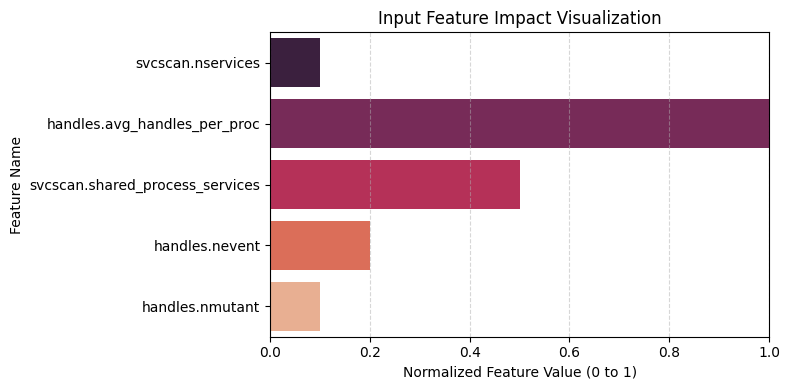


Do you want to make another prediction? (yes/no):  no



Prediction session ended.


In [36]:
def visualize_feature_impact(instance, selected_features):
    feature_values = instance.values.flatten()
    plt.figure(figsize=(8, 4))
    sns.barplot(x=feature_values, y=selected_features, palette='rocket')
    plt.title("Input Feature Impact Visualization")
    plt.xlabel("Normalized Feature Value (0 to 1)")
    plt.ylabel("Feature Name")
    plt.xlim(0, 1)
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def predict_instance(rfc, scaler, selected_features, mode='manual', choosen_index=None, df_to_predict=None):
    if mode == 'manual':
        print("\nManual Mode: Please input values for the top 5 features (between 0 and 1)")
        user_input = []
        for feature in selected_features:
            while True:
                try:
                    val = float(input(f"Enter value for '{feature}' (0 to 1): "))
                    if 0.0 <= val <= 1.0:
                        user_input.append(val)
                        break
                    else:
                        print("Please enter a value between 0 and 1.")
                except ValueError:
                    print("Invalid input. Please enter a numeric value.")
        
        choosen_instance = pd.DataFrame([user_input], columns=selected_features)

    elif mode == 'dataset':
        if choosen_index is None or df_to_predict is None:
            raise ValueError("For 'dataset' mode, 'choosen_index' and 'df_to_predict' must be provided.")

        if choosen_index not in df_to_predict.index:
            print(f"Index {choosen_index} not found in dataset. Please try again.")
            return

        print("\nOriginal feature values for the selected index:")
        print(df_to_predict.loc[choosen_index, selected_features])

        # Prepare scaled instance
        X_new = df_to_predict[selected_features]
        X_new_scaled = scaler.transform(X_new)
        X_new_scaled = pd.DataFrame(X_new_scaled, columns=selected_features, index=X_new.index)
        choosen_instance = X_new_scaled.loc[[choosen_index]]
    else:
        raise ValueError("Invalid mode. Use 'manual' or 'dataset'.")

    # Predict using trained model
    prediction = rfc.predict(choosen_instance)[0]
    result = "Malware" if prediction == 1 else "Benign"
    print(f"\n✅ Prediction: The given instance is classified as: *{result}*")

    # Visualize impact of each feature value
    print("\nVisualizing input feature values and their impact...")
    visualize_feature_impact(choosen_instance, selected_features)


# === Controlled Prediction Loop ===

while True:
    print("\n================ Random Forest Malware Prediction ================\n")
    print("Choose prediction mode:")
    print("1. Manual input of feature values")
    print("2. Use instance from dataset (by entering index)")

    choice = input("Enter your choice (1 or 2): ").strip()

    if choice == '1':
        predict_instance(rfc, scaler, selected_features1, mode='manual')

    elif choice == '2':
        try:
            index_input = int(input("Enter the index of the instance from the dataset: "))
            predict_instance(rfc, scaler, selected_features1, mode='dataset', choosen_index=index_input, df_to_predict=df_to_predict)
        except ValueError:
            print("Invalid input. Please enter a valid numeric index.")
    else:
        print("Invalid choice. Please enter 1 or 2.")
        continue

    # Ask to continue
    cont = input("\nDo you want to make another prediction? (yes/no): ").strip().lower()
    if cont != 'yes':
        print("\nPrediction session ended.")
        break


================ Random Forest Malware Prediction ================

Choose prediction mode:
1. Manual input of feature values
2. Use instance from dataset (by entering index)
3. SHAP Explanation


Enter your choice (1, 2, or 3):  3



=== SHAP Explanation Mode ===

Choose SHAP visualization:
1: SHAP Beeswarn plot(Top features)(Global Interpretation)
2. SHAP Summary Plot


Enter your choice (1 or 2):  2



📈 Model Accuracy: 99.99%
X_train shape: (46876, 52)
X_test shape: (11720, 52)

 Showing SHAP Summary Plot for Class 0 (Benign)...


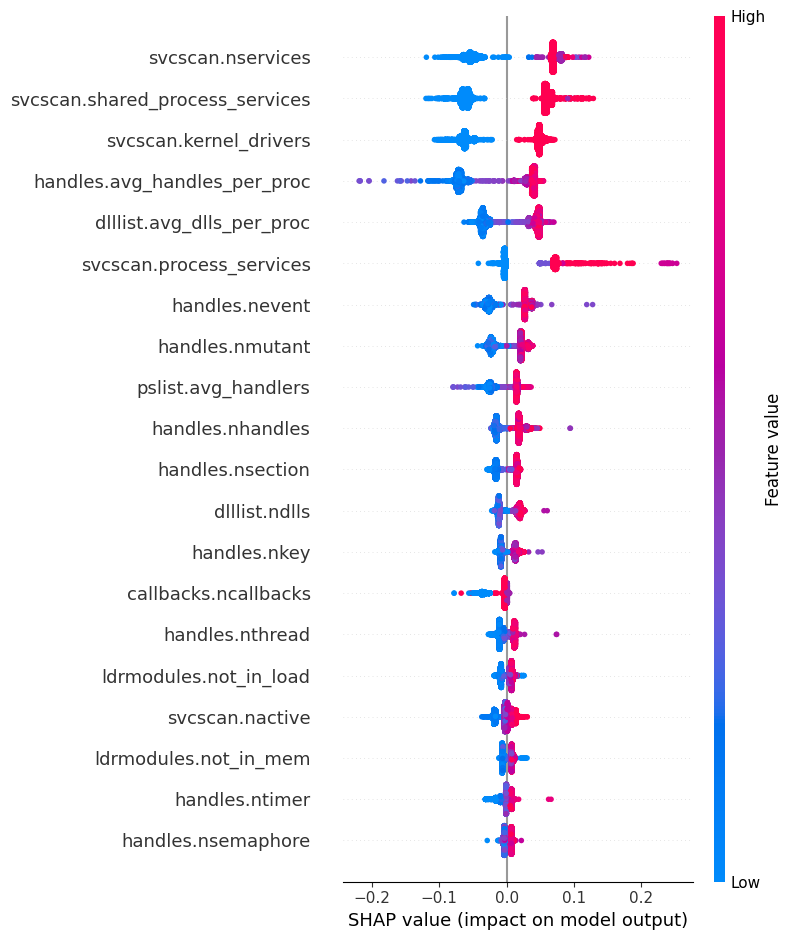


 Showing SHAP Summary Plot for Class 1 (Malware)...


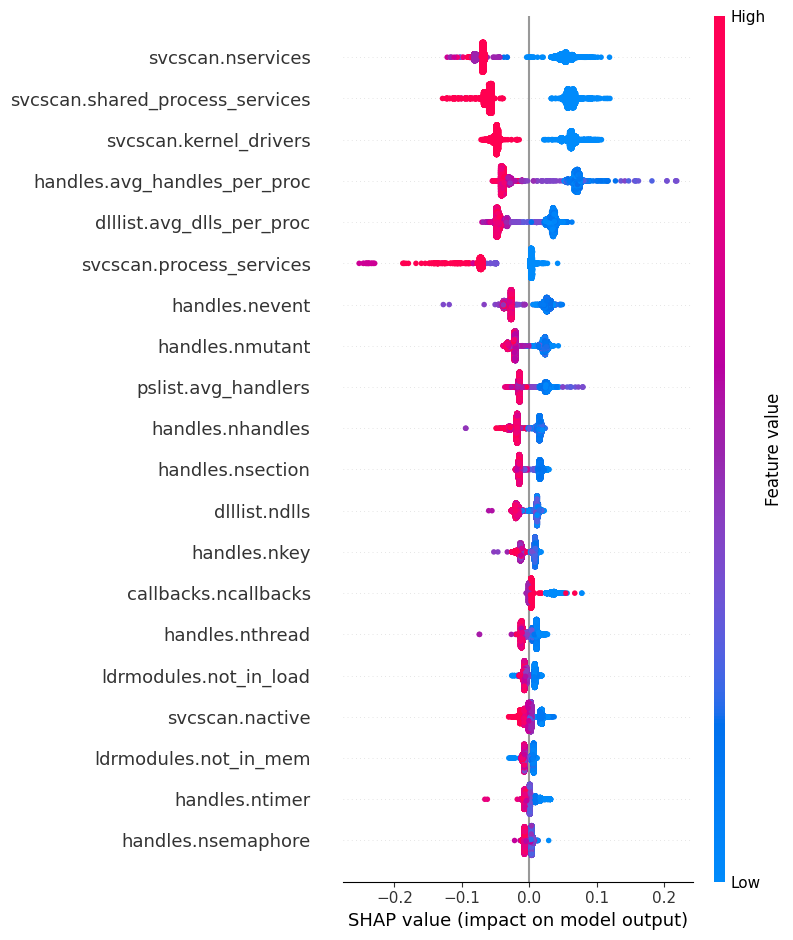


Do you want to make another prediction or visualization? (yes/no):  no



 Prediction session ended.


In [34]:
def visualize_feature_impact(instance, selected_features):
    feature_values = instance.values.flatten()
    plt.figure(figsize=(8, 4))
    sns.barplot(x=feature_values, y=selected_features, hue=selected_features, palette='coolwarm', legend=False)
    plt.title("Input Feature Impact Visualization")
    plt.xlabel("Normalized Feature Value (0 to 1)")
    plt.ylabel("Feature Name")
    plt.xlim(0, 1)
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

def predict_instance(rfc, scaler, selected_features, mode='manual', choosen_index=None, df_to_predict=None):
    if mode == 'manual':
        print("\nManual Mode: Please input values for the top 5 features (between 0 and 1)")
        user_input = []
        for feature in selected_features:
            while True:
                try:
                    val = float(input(f"Enter value for '{feature}' (0 to 1): "))
                    if 0.0 <= val <= 1.0:
                        user_input.append(val)
                        break
                    else:
                        print("Please enter a value between 0 and 1.")
                except ValueError:
                    print("Invalid input. Please enter a numeric value.")
        choosen_instance = pd.DataFrame([user_input], columns=selected_features)

    elif mode == 'dataset':
        if choosen_index is None or df_to_predict is None:
            raise ValueError("For 'dataset' mode, 'choosen_index' and 'df_to_predict' must be provided.")
        if choosen_index not in df_to_predict.index:
            print(f"Index {choosen_index} not found in dataset. Please try again.")
            return
        print("\nOriginal feature values for the selected index:")
        print(df_to_predict.loc[choosen_index, selected_features])
        X_new = df_to_predict[selected_features]
        X_new_scaled = scaler.transform(X_new)
        X_new_scaled = pd.DataFrame(X_new_scaled, columns=selected_features, index=X_new.index)
        choosen_instance = X_new_scaled.loc[[choosen_index]]
    else:
        raise ValueError("Invalid mode. Use 'manual' or 'dataset'.")

    prediction = rfc.predict(choosen_instance)[0]
    result = "Malware" if prediction == 1 else "Benign"
    print(f"\n Prediction: The given instance is classified as: {result}")
    print("\nVisualizing input feature values and their impact...")
    visualize_feature_impact(choosen_instance, selected_features)

# === Controlled Prediction Loop ===
while True:
    print("\n================ Random Forest Malware Prediction ================\n")
    print("Choose prediction mode:")
    print("1. Manual input of feature values")
    print("2. Use instance from dataset (by entering index)")
    print("3. SHAP Explanation")

    choice = input("Enter your choice (1, 2, or 3): ").strip()

    if choice == '1':
        predict_instance(rfc, scaler, selected_features1, mode='manual')

    elif choice == '2':
        try:
            index_input = int(input("Enter the index of the instance from the dataset: "))
            predict_instance(rfc, scaler, selected_features1, mode='dataset', choosen_index=index_input, df_to_predict=df_to_predict)
        except ValueError:
            print("Invalid input. Please enter a valid numeric index.")

    elif choice == '3':
        print("\n=== SHAP Explanation Mode ===")
        print("\nChoose SHAP visualization:")
        print("1: SHAP Beeswarn plot(Top features)(Global Interpretation)")
        print("2. SHAP Summary Plot")

        sub_choice = input("Enter your choice (1 or 2): ").strip()

        if sub_choice == '1':
            print("\n Showing SHAP BeeSwarn plot...")
            shap.initjs()
            shap_values = explainer(X_new_scaled,check_additivity=False)
            beeswarm(shap_values[:,:,1])
        elif sub_choice == '2':

            IFrame('force_plot_malware2.html', width=1000, height=200)
            x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    
            rfc_local = RandomForestClassifier(n_estimators=100, random_state=42)
            rfc_local.fit(x_train, y_train)
    
            y_pred = rfc_local.predict(x_test)
            acc = accuracy_score(y_test, y_pred) * 100
            print(f"\n📈 Model Accuracy: {acc:.2f}%")
            print("X_train shape:", x_train.shape)
            print("X_test shape:", x_test.shape)
    
            explainer = shap.TreeExplainer(rfc_local)
            shap_values = explainer.shap_values(x_test[:], check_additivity=False)
            print("\n Showing SHAP Summary Plot for Class 0 (Benign)...")
            shap.initjs()
            shap.summary_plot(
                shap_values=shap_values[:,:,0],
                features=x_test[:],
                feature_names=x_test.columns
            )
            '''shap.save_html("force_plot_malwareguess.html", force_plot)
            from IPython.display import IFrame
            IFrame('force_plot_malware2.html', width=1000, height=200)'''
            print("\n Showing SHAP Summary Plot for Class 1 (Malware)...")
            shap.initjs()
            shap.summary_plot(
                shap_values=shap_values[:,:,1],  # SHAP values for the specified class "1==class malware"
                features=x_test[:],  # Reshaped feature matrix
                feature_names=x_test.columns  # Feature names
            )
            '''shap.save_html("force_plot_malwareguess.html", force_plot)
            from IPython.display import IFrame
            IFrame('force_plot_malware2.html', width=1000, height=200)'''
            
        else:
            print(" Invalid sub-choice. Returning to main menu.")
    else:
        print("Invalid choice. Please enter 1, 2, or 3.")
        continue

    cont = input("\nDo you want to make another prediction or visualization? (yes/no): ").strip().lower()
    if cont != 'yes':
        print("\n Prediction session ended.")
        break

In [ ]:
evaluate_classifier_with_metrics(X,Y,model,model,cv_folds=10)
model=RandomForestClassifier(random_state=0)
selected_features_df = feature_importance_all(model, df)
selected_features_df
feature_frequencies = selected_features_df['Feature'].value_counts()

# Convert the result to a DataFrame for better presentation
feature_frequencies_df = pd.DataFrame({'Feature': feature_frequencies.index, 'Frequency': feature_frequencies.values})
feature_frequencies_df= feature_frequencies_df.sort_values(by=['Feature', 'Frequency'], ascending=[False, False])

# Print the DataFrame sorted by frequency
feature_frequencies_df
selected_features=feature_importance(model, malware_sub)
print(selected_features)
train_predict_novel_malware_2(malware_sub, selected_features)
predict_instance(rfc, scaler, selected_features1, mode='manual'